In [ ]:

# Import the kagglehub helper library
!pip install decord
!pip install num2words
import torchvision
import os
import shutil
import zipfile
import glob
import json
import io
import re
import math
import random
import numpy as np
from functools import reduce
from scipy.signal import stft
import pywt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import cv2
import matplotlib.pyplot as plt
plt.switch_backend('Agg')
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
import torchvision.models as tvm
from torchvision import transforms
from tqdm import tqdm
from num2words import num2words
import kagglehub
from torchvision.models import resnet
import torch
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline

#----------------------------------------------
#     1st Dataset
#-----------------------------------------------
# Define the Kaggle dataset reference
# This points to the “American Sign Language Dataset” published by deeppythonist
asl_dataset = "deeppythonist/american-sign-language-dataset"

# Download (and extract) the latest version of the dataset
# The returned `path` is the local directory containing all dataset files
path = kagglehub.dataset_download(asl_dataset)

# Confirm where the files live on disk
print(f"Downloaded '{asl_dataset}' → {path}")

# Peek at the directory structure

print("\nDataset directory contents:")
for root, dirs, files in os.walk(path):
    level = root.replace(path, "").count(os.sep)
    indent = " " * 4 * level
    print(f"{indent}{os.path.basename(root)}/")
    for fname in files:
        print(f"{indent}    {fname}")

Downloaded 'deeppythonist/american-sign-language-dataset' → /kaggle/input/american-sign-language-dataset

Dataset directory contents:
american-sign-language-dataset/
    ASL_Gestures_36_Classes/
        test/
            n/
                hand1_n_left_seg_5_cropped.jpeg
                hand2_n_top_seg_4_cropped.jpeg
                hand1_n_dif_seg_2_cropped.jpeg
                hand3_n_dif_seg_1_cropped.jpeg
                hand2_n_dif_seg_2_cropped.jpeg
                hand1_n_left_seg_1_cropped.jpeg
                hand2_n_right_seg_4_cropped.jpeg
                hand1_n_dif_seg_5_cropped.jpeg
                hand1_n_top_seg_4_cropped.jpeg
                hand1_n_bot_seg_4_cropped.jpeg
                hand4_n_bot_seg_5_cropped.jpeg
                hand1_n_dif_seg_4_cropped.jpeg
                hand4_n_bot_seg_3_cropped.jpeg
                hand1_n_top_seg_5_cropped.jpeg
            7/
                hand2_7_right_seg_3_cropped.jpeg
                hand5_7_bot_seg_1_cropped.jpeg
   

Found 36 classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Plot saved as 'random_sample.png'


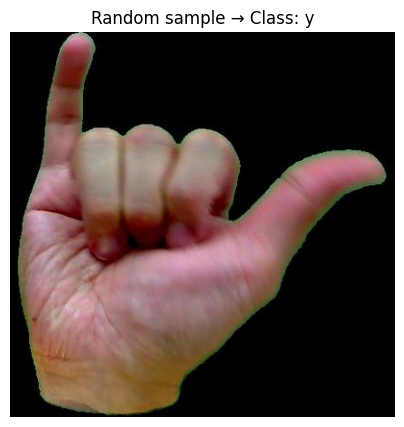

In [ ]:


def display_random_sample(dataset_root, save_path="random_sample.png"):
    """
    Displays and saves a random sample image from the ASL_Gestures_36_Classes dataset.

    Parameters:
    - dataset_root (str): Root directory where the dataset is located.
    - save_path (str): Path to save the output image file.
    """
    # Define training directory
    train_dir = os.path.join(dataset_root, "ASL_Gestures_36_Classes", "train")

    # List all gesture classes
    asl_classes = sorted(os.listdir(train_dir))
    print(f"Found {len(asl_classes)} classes:", asl_classes)

    # Choose a random class and image
    chosen_class = random.choice(asl_classes)
    class_folder = os.path.join(train_dir, chosen_class)
    img_name = random.choice(os.listdir(class_folder))
    img_path = os.path.join(class_folder, img_name)

    # Read and convert image to RGB
    bgr_img = cv2.imread(img_path)
    rgb_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)

    # Plot and save the image
    plt.figure(figsize=(5, 5))
    plt.imshow(rgb_img)
    plt.title(f"Random sample → Class: {chosen_class}")
    plt.axis("off")
    plt.savefig(save_path)
    print(f"Plot saved as '{save_path}'")

    return chosen_class, img_path
# Call the function with your dataset path
chosen_class, img_path = display_random_sample(path)


In [ ]:


# Point to train folder and build filepaths + labels
train_dir   = os.path.join(path, "ASL_Gestures_36_Classes", "train")
asl_classes = sorted(os.listdir(train_dir))
asl_label_map   = {cls: idx for idx, cls in enumerate(asl_classes)}

filepaths, labels = [], []
for cls in asl_classes:
    folder = os.path.join(train_dir, cls)
    for fname in os.listdir(folder):
        if fname.lower().endswith((".jpg",".jpeg",".png")):
            filepaths.append(os.path.join(folder, fname))
            labels.append(asl_label_map[cls])

assert len(filepaths) == len(labels)

# Stratified 80/20 split
fp_train, fp_val, lbl_train, lbl_val = train_test_split(
    filepaths, labels,
    test_size=0.2,
    stratify=labels,
    random_state=42
)

# Transforms & Dataset class
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485,0.456,0.406],
        std=[0.229,0.224,0.225]
    )
])

class ASLGesturesDataset(Dataset):
    def __init__(self, fps, lbs, transform=None):
        self.fps       = fps
        self.lbs       = lbs
        self.transform = transform

    def __len__(self):
        return len(self.fps)

    def __getitem__(self, idx):
        img = Image.open(self.fps[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, self.lbs[idx]

# DataLoaders
train_img_ds = ASLGesturesDataset(fp_train, lbl_train, transform=transform)
val_img_ds   = ASLGesturesDataset(fp_val,   lbl_val,   transform=transform)

train_loader = DataLoader(train_img_ds, batch_size=32, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_img_ds,   batch_size=32, shuffle=False, num_workers=2)

# Sanity‐check batch
imgs, tgts = next(iter(train_loader))
print("Train images:", imgs.shape, "Train labels:", tgts.shape)


Train images: torch.Size([32, 3, 224, 224]) Train labels: torch.Size([32])


In [ ]:
#----------------------------------------------
#     2nd Dataset
#-----------------------------------------------
# Fetch the preprocessed word‐level ASL dataset from Kaggle.
# Here we’re pulling the “wlasl‐processed” collection prepared by risangbaskoro.
dataset_name = "risangbaskoro/wlasl-processed"
download_path = kagglehub.dataset_download(dataset_name)

# When the download and extraction finish, download_path
# holds the local directory containing all dataset files.
print("Path to dataset files:", download_path)


Path to dataset files: /kaggle/input/wlasl-processed


In [ ]:

# Paths
WLASL_ROOT  = "/kaggle/input/wlasl-processed"
VIDEOS_DIR  = os.path.join(WLASL_ROOT, "videos")
META_FP     = os.path.join(WLASL_ROOT, "WLASL_v0.3.json")
OUTPUT_ROOT = "wlasl_word_level"

os.makedirs(OUTPUT_ROOT, exist_ok=True)

# Load metadata JSON
with open(META_FP, "r") as f:
    metadata = json.load(f)

# Flatten entries → DataFrame
records = []
for entry in metadata:
    gloss = entry["gloss"]
    for inst in entry["instances"]:
        records.append({
            "gloss":         gloss,
            "video_id":      inst["video_id"],
            "instance_id":   inst["instance_id"],
            "signer_id":     inst["signer_id"],
            "source":        inst["source"],
            "split":         inst["split"],
            "url":           inst["url"],
            "fps":           inst["fps"],
            "frame_start":   inst["frame_start"],
            "frame_end":     inst["frame_end"],
            "bbox_x1":       inst["bbox"][0],
            "bbox_y1":       inst["bbox"][1],
            "bbox_x2":       inst["bbox"][2],
            "bbox_y2":       inst["bbox"][3],
            "variation_id":  inst.get("variation_id", -1)
        })

wlasl_df = pd.DataFrame.from_records(records)

# Show a sample & some stats
print("=== DataFrame head ===")
print(wlasl_df.head(3).to_markdown(index=False), end="\n\n")

print("=== Split distribution ===")
print(wlasl_df["split"].value_counts(), end="\n\n")

print("=== Top-5 gloss by unique instances ===")
print(
    wlasl_df
      .groupby("gloss")["instance_id"]
      .nunique()
      .sort_values(ascending=False)
      .head()
)

# Export videos into split/gloss folders, skipping existing files
for split, split_df in wlasl_df.groupby("split"):
    for gloss, group in split_df.groupby("gloss"):
        dest_dir = os.path.join(OUTPUT_ROOT, split, gloss)
        os.makedirs(dest_dir, exist_ok=True)

        for vid_id in group["video_id"].unique():
            src = os.path.join(VIDEOS_DIR, f"{vid_id}.mp4")
            dst = os.path.join(dest_dir, f"{vid_id}.mp4")

            # only link/copy if source exists & destination is missing
            if os.path.isfile(src) and not os.path.exists(dst):
                try:
                    os.link(src, dst)
                except OSError:
                    shutil.copy2(src, dst)

print("\nFinished organizing videos under:", OUTPUT_ROOT)


=== DataFrame head ===
| gloss   |   video_id |   instance_id |   signer_id | source       | split   | url                                                                                            |   fps |   frame_start |   frame_end |   bbox_x1 |   bbox_y1 |   bbox_x2 |   bbox_y2 |   variation_id |
|:--------|-----------:|--------------:|------------:|:-------------|:--------|:-----------------------------------------------------------------------------------------------|------:|--------------:|------------:|----------:|----------:|----------:|----------:|---------------:|
| book    |      69241 |             0 |         118 | aslbrick     | train   | http://aslbricks.org/New/ASL-Videos/book.mp4                                                   |    25 |             1 |          -1 |       385 |        37 |       885 |       720 |              0 |
| book    |      65225 |             1 |          90 | aslsignbank  | train   | https://aslsignbank.haskins.yale.edu/dictionary/protected

In [ ]:
from decord import VideoReader, cpu
from decord._ffi.base import DECORDError
import numpy as np
import os

def load_and_crop_decord(video_path, row, num_frames=16):
    """Read up to num_frames evenly spaced frames via Decord.
       If Decord fails, raise RuntimeError so caller can skip or fallback."""
    try:
        # force single‐threaded decode to avoid filter graph races
        vr = VideoReader(
            str(video_path),
            ctx=cpu(0),
            num_threads=1
        )
    except DECORDError as e:
        raise RuntimeError(f"Decord cannot open {video_path}: {e}")

    total = len(vr)
    start = max(0, row.frame_start - 1)
    # clamp negative or out‐of‐range ends
    end   = (row.frame_end - 1) if row.frame_end > 0 else (total - 1)
    end   = min(max(end, start), total - 1)

    idxs  = np.linspace(start, end, num_frames, dtype=int)

    # now decode and crop
    try:
        frames = vr.get_batch(idxs).asnumpy()  # (T, H, W, 3)
    except DECORDError as e:
        raise RuntimeError(f"Decord get_batch failed on {video_path}: {e}")

    if frames.size == 0:
        raise RuntimeError(f"no frames for {os.path.basename(video_path)}")

    x1, y1, x2, y2 = row.bbox_x1, row.bbox_y1, row.bbox_x2, row.bbox_y2
    return frames[:, y1:y2, x1:x2, :]



working_rows = []
for gloss, group in wlasl_df.groupby("gloss"):
    for _, row in group.iterrows():
        vp = os.path.join(VIDEOS_DIR, f"{row.video_id}.mp4")
        if not os.path.isfile(vp):
            continue
        try:
            load_and_crop_decord(vp, row, num_frames=16)
            working_rows.append(row)
            break
        except RuntimeError:
            continue



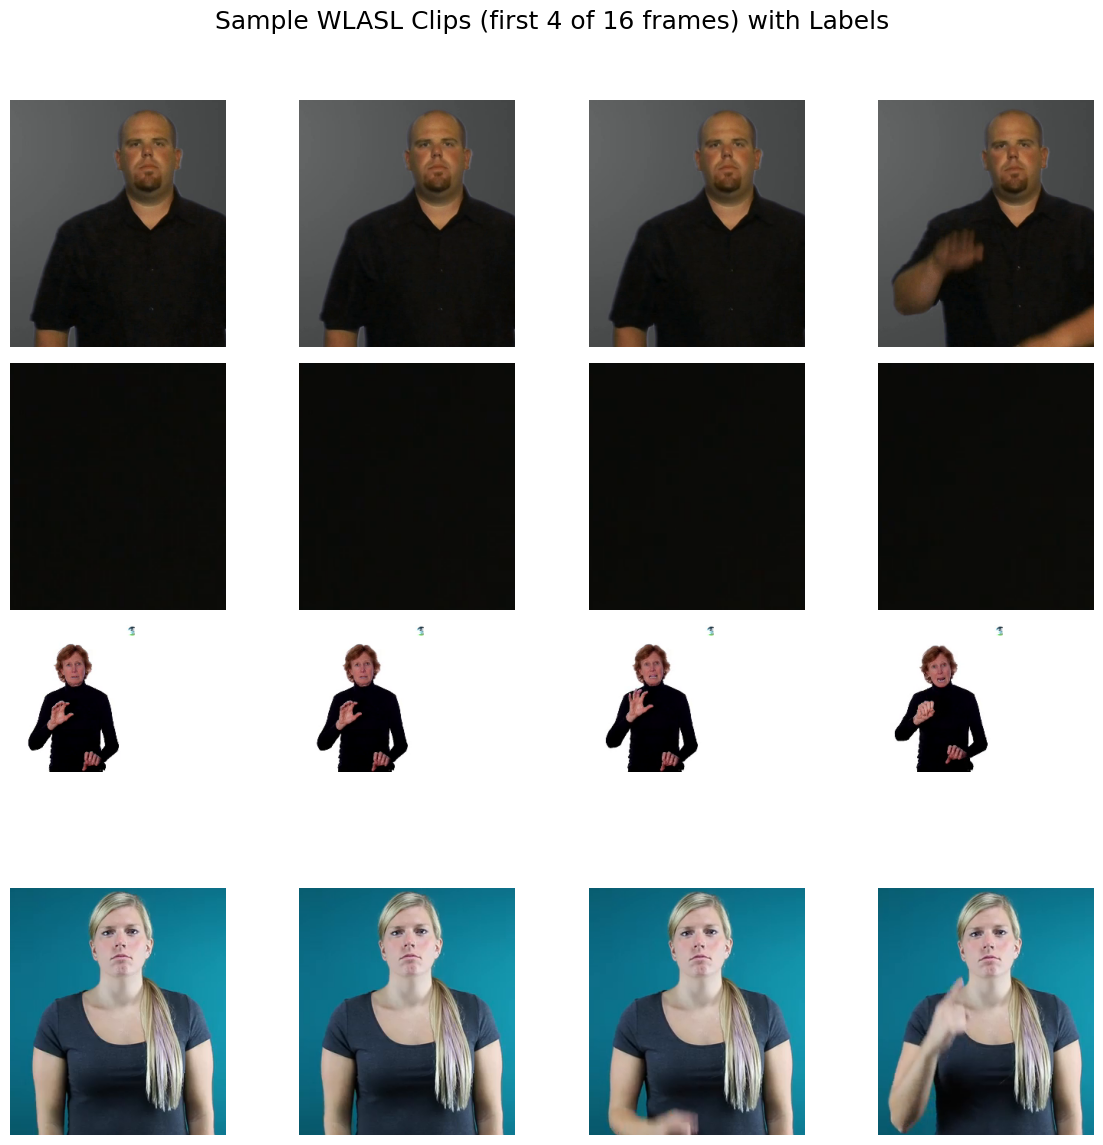

In [ ]:
# now randomly pick 4 gloss‐instances that we know work
sample_rows = random.sample(working_rows, k=4)

# Plot their first 4 frames each
fig, axes = plt.subplots(4, 4, figsize=(12, 12), sharex=True, sharey=True)
for i, row in enumerate(sample_rows):
    clip = load_and_crop_decord(
        os.path.join(VIDEOS_DIR, f"{row.video_id}.mp4"),
        row, num_frames=16
    )
    axes[i, 0].set_ylabel(row.gloss, fontsize=14)
    for j in range(4):
        axes[i, j].imshow(clip[j])
        axes[i, j].axis("off")

plt.suptitle("Sample WLASL Clips (first 4 of 16 frames) with Labels", fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
# ——— Build a cleaned DataFrame of *all* loadable clips ———
vid_labels = []
# We convert it back into a proper DataFrame:
working_df = pd.DataFrame(working_rows).reset_index(drop=True)

# want *all* splits, skip the split filter; otherwise:
train_working_df = working_df[working_df.split == "train"].reset_index(drop=True)

print("→ Ready WLASL rows:", len(train_working_df))

# ——— Define the per-frame transform ———

frame_tfm = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])



class WLASLDataset(Dataset):
    def __init__(self, df, videos_dir, transform=None, target_frames=100):
        self.df            = df.reset_index(drop=True)
        self.videos_dir    = videos_dir
        self.transform     = transform
        self.target_frames = target_frames
        glosses = sorted(self.df.gloss.unique())
        self.label2idx = {g:i for i,g in enumerate(glosses)}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row   = self.df.iloc[idx]
        vidfp = os.path.join(self.videos_dir, f"{row.video_id}.mp4")
        cap   = cv2.VideoCapture(vidfp)
        total= int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        start= max(0, row.frame_start-1)
        end  = total-1 if row.frame_end<0 else (row.frame_end-1)
        idxs = np.linspace(start, end, self.target_frames, dtype=int)

        frames = []
        for f in idxs:
            cap.set(cv2.CAP_PROP_POS_FRAMES, int(f))
            ret, img = cap.read()
            if not ret or img is None or img.size==0:
                # black placeholder
                img = np.zeros((224,224,3), dtype=np.uint8)
            else:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            if self.transform:
                frame = self.transform(img)  # C×H×W
            else:
                frame = torch.from_numpy(img).permute(2,0,1).float()/255.0

            frames.append(frame)
        cap.release()

        # stack to (T, C, H, W), then permute to (C, T, H, W)
        clip = torch.stack(frames, dim=0).permute(1,0,2,3)
        vid_labels= self.label2idx[row.gloss]
        return clip, torch.tensor(vid_labels, dtype=torch.long)


# ——— Instantiate the dataset & loader ———

VIDEOS_DIR = os.path.join(download_path, "videos")  # our kagglehub path

wlasl_ds = WLASLDataset(
    df=train_working_df,
    videos_dir=VIDEOS_DIR,
    transform=frame_tfm,
    target_frames=100
)
wlasl_loader = DataLoader(
    wlasl_ds,
    batch_size=16,
    shuffle=True,
    num_workers=2,           # ← single process
    pin_memory=False,        # no pinned CPU→GPU copy needed
    persistent_workers=False
)



# ——— Sanity check shapes ———

clips, vid_labels = next(iter(wlasl_loader))
print("clips:",  clips.shape)   # [B, 3, 100, 224, 224]
print("labels:", vid_labels.shape)  # [B]


→ Ready WLASL rows: 1112
clips: torch.Size([16, 3, 100, 224, 224])
labels: torch.Size([16])


In [ ]:
# Invert dataset.label2idx to get idx→gloss
idx2label = {idx: gloss for gloss, idx in wlasl_ds.label2idx.items()}

# Grab one batch
clips, vid_labels = next(iter(wlasl_loader))  # vid_labels: tensor of shape [B]

# Convert each index to its string label
batch_glosses = [ idx2label[int(i)] for i in vid_labels ]

print("Batch glosses:", batch_glosses)


Batch glosses: ['basement', 'shrimp', 'coat', 'fight', 'bookstore', 'drive', 'salt', 'toilet', 'english', 'witness', 'later', 'motorcycle', 'different', 'grow', 'radio', 'elevator']


In [ ]:
import torch
import torch.nn as nn
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from pathlib import Path
import numpy as np
from tqdm import tqdm
import glob
# Choose CPU as the device
device = torch.device("cpu")

# Load EfficientNet-B0 without its classifier head
weights = EfficientNet_B0_Weights.IMAGENET1K_V1
enet = efficientnet_b0(weights=weights)

# Strip off the final classifier and flatten output
backbone = nn.Sequential(
    *list(enet.children())[:-1],  # all conv/pool layers
    nn.Flatten()                  # [B, 1280]
)

# Projection head: 1280 → 512
projection = nn.Linear(in_features=1280, out_features=512)

# Combine and move to CPU
feature_extractor = nn.Sequential(backbone, projection).to(device)
feature_extractor.eval()
cache_dir = Path("feature_cache")
cache_dir.mkdir(parents=True, exist_ok=True)

all_feats  = []
all_labels = []

with torch.no_grad():
    for batch_idx, (imgs, labels) in enumerate(tqdm(train_loader, desc="Extracting image features")):
        # Ensure inputs are on CPU
        imgs = imgs.to(device)
        labels = labels.to(device)

        # Forward pass (float32)
        feats = feature_extractor(imgs)         # [B, 512], float32

        # Convert to float16 for storage
        feats_cpu  = feats.detach().half()       # [B, 512], float16
        labels_cpu = labels.detach()             # [B], int64

        # Append to lists
        all_feats.append(feats_cpu)
        all_labels.append(labels_cpu)

# Concatenate all batches into single tensors
image_features = torch.cat(all_feats, dim=0)   # [N, 512]
image_labels   = torch.cat(all_labels, dim=0)  # [N]

print("Features shape:", image_features.shape)
print("Labels shape:  ", image_labels.shape)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 73.0MB/s]
Extracting image features: 100%|██████████| 51/51 [02:17<00:00,  2.69s/it]

Features shape: torch.Size([1608, 512])
Labels shape:   torch.Size([1608])


In [ ]:
import torch
import torch.nn as nn
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from pathlib import Path
from torch.utils.data import DataLoader, Dataset
import numpy as np
from tqdm import tqdm
import cv2, os, pandas as pd
from torchvision import transforms

device = torch.device("cpu")



# ——— Define Spatial + Temporal Models on CPU ———

# Spatial: EfficientNet-B0 → 512‐dim projection
weights       = EfficientNet_B0_Weights.IMAGENET1K_V1
enet          = efficientnet_b0(weights=weights)
backbone      = nn.Sequential(*list(enet.children())[:-1], nn.Flatten())
projection    = nn.Linear(1280, 512)
spatial_model = nn.Sequential(backbone, projection).to(device).eval()

# Temporal: LSTM fusion of 512→256→512
class TemporalFusion(nn.Module):
    def __init__(self, feat_dim=512, hidden_dim=256, out_dim=512):
        super().__init__()
        self.lstm = nn.LSTM(feat_dim, hidden_dim, batch_first=True)
        self.fc   = nn.Linear(hidden_dim, out_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        last   = out[:, -1, :]
        return self.fc(last)

temporal_model = TemporalFusion().to(device).eval()

# ——— Prepare Output Containers & Cache Dir ———

video_features = []   # ← initialize here
video_labels   = []   # ← initialize here

cache_dir = Path("video_feat_cache")
cache_dir.mkdir(exist_ok=True)

# ——— Extraction Loop ———

with torch.no_grad():
    for vid_idx, (clips, labels) in enumerate(tqdm(wlasl_loader, desc="Extracting vids (CPU)")):
        B, C, T, H, W = clips.shape

        # Flatten to frames
        frames = clips.permute(0,2,1,3,4).reshape(-1, C, H, W)

        # Chunked spatial pass
        sp_feats_list = []
        for start in range(0, frames.size(0), 64):
            chunk = frames[start:start+64]
            feats = spatial_model(chunk)       # [n, 512]
            sp_feats_list.append(feats)
        sp_feats = torch.cat(sp_feats_list, 0).view(B, T, -1)

        # Temporal fusion
        tm_feats = temporal_model(sp_feats)    # [B, 512]

        # Collect results
        video_features.append(tm_feats.cpu())
        video_labels.append(labels)

# ——— Concatenate All Videos ———

video_features = torch.cat(video_features, dim=0)  # [N_videos, 512]
video_labels   = torch.cat(video_labels,   dim=0)  # [N_videos]

print("Features:", video_features.shape)
print("Labels:  ", video_labels.shape)


Extracting vids (CPU): 100%|██████████| 70/70 [3:57:46<00:00, 203.80s/it]


Features: torch.Size([1112, 512])
Labels:   torch.Size([1112])


In [ ]:
merged_features = torch.cat([image_features, video_features])
merged_labels   = torch.cat([image_labels, video_labels])
print("Merged features:", merged_features.shape)
print("Merged labels:", merged_labels.shape)


Merged features: torch.Size([2720, 512])
Merged labels: torch.Size([2720])


In [ ]:
#----------------------------------------------
#     3rd Dataset
#-----------------------------------------------
# Specify the path to the downloaded ZIP archive
zip_path = "/content/ASL-Sensor-Dataglove-Dataset.zip"

# Define where you want to unpack the archive
extract_to = "/content/dataglove_dataset"

# Ensure the output directory exists; if not, create it
#    exist_ok=True prevents an error if the directory is already there
os.makedirs(extract_to, exist_ok=True)

# Open the ZIP file in ‘read’ mode and extract all contents
with zipfile.ZipFile(zip_path, mode="r") as zip_ref:
    # Extract every file/folder inside the ZIP into the target directory
    zip_ref.extractall(path=extract_to)

# Confirm to the user that extraction has finished and point to the folder
print(f"Dataset extraction complete. Files are now available at: {extract_to}")


Dataset extraction complete. Files are now available at: /content/dataglove_dataset


In [ ]:
import glob
import os
from sklearn.model_selection import train_test_split

# Map gesture name → all CSVs
root_dir = "/content/dataglove_dataset/ASL-Sensor-Dataglove-Dataset"
gesture_to_files = {}
for part in os.listdir(root_dir):
    part_dir = os.path.join(root_dir, part)
    for fp in glob.glob(os.path.join(part_dir, "*.csv")):
        gesture = os.path.splitext(os.path.basename(fp))[0]
        gesture_to_files.setdefault(gesture, []).append(fp)

# Create flat lists
filepaths, labels = [], []
gestures = sorted(gesture_to_files.keys())
gesture2idx = {g:i for i,g in enumerate(gestures)}

for g, fps in gesture_to_files.items():
    idx = gesture2idx[g]
    for fp in fps:
        filepaths.append(fp)
        labels.append(idx)

# Stratified train/val split
fp_train, fp_val, lbl_train, lbl_val = train_test_split(
    filepaths, labels,
    test_size=0.2,
    stratify=labels,
    random_state=42
)


In [ ]:

# 1) Print just the gesture names
print("Original gesture labels:")
for g in gestures:
    print(f" - {g}")

# 2) Print each gesture with its numeric ID
print("\nGesture → Index mapping:")
for g, idx in gesture2idx.items():
    print(f" {idx:3d} → {g}")

Original gesture labels:
 - a
 - b
 - bad
 - c
 - d
 - deaf
 - e
 - f
 - fine
 - g
 - good
 - goodbye
 - h
 - hello
 - hungry
 - i
 - j
 - k
 - l
 - m
 - me
 - n
 - no
 - o
 - p
 - please
 - q
 - r
 - s
 - sorry
 - t
 - thankyou
 - u
 - v
 - w
 - x
 - y
 - yes
 - you
 - z

Gesture → Index mapping:
   0 → a
   1 → b
   2 → bad
   3 → c
   4 → d
   5 → deaf
   6 → e
   7 → f
   8 → fine
   9 → g
  10 → good
  11 → goodbye
  12 → h
  13 → hello
  14 → hungry
  15 → i
  16 → j
  17 → k
  18 → l
  19 → m
  20 → me
  21 → n
  22 → no
  23 → o
  24 → p
  25 → please
  26 → q
  27 → r
  28 → s
  29 → sorry
  30 → t
  31 → thankyou
  32 → u
  33 → v
  34 → w
  35 → x
  36 → y
  37 → yes
  38 → you
  39 → z


In [ ]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset

class SensorGloveDataset(Dataset):
    def __init__(self, fps, lbs, seq_len=100, normalize=True):
        """
        fps: list of CSV file paths
        lbs: list of integer labels
        seq_len: number of time‐steps per sample
        normalize: True → z‐score per channel
        """
        self.fps      = fps
        self.lbs      = lbs
        self.seq_len  = seq_len
        self.normalize = normalize

    def __len__(self):
        return len(self.fps)

    def __getitem__(self, idx):
        # Load CSV and drop non‐sensor cols
        df = pd.read_csv(self.fps[idx])
        df = df.drop(["timestamp", "user_id"], axis=1)
        data = df.values  # shape: [T_raw, C]

        #  Sample or pad to seq_len
        T_raw, C = data.shape
        if T_raw >= self.seq_len:
            # evenly spaced indices
            idcs = np.linspace(0, T_raw-1, self.seq_len, dtype=int)
            data_seq = data[idcs]
        else:
            # pad with zeros at end
            pad = np.zeros((self.seq_len - T_raw, C), dtype=data.dtype)
            data_seq = np.vstack([data, pad])

        #  Normalize per channel (optional)
        if self.normalize:
            mu = data_seq.mean(axis=0, keepdims=True)
            sd = data_seq.std(axis=0, keepdims=True) + 1e-8
            data_seq = (data_seq - mu) / sd

        # Convert to tensor [seq_len, C]
        return torch.tensor(data_seq, dtype=torch.float32), self.lbs[idx]


In [ ]:
from torch.utils.data import DataLoader

#  Create datasets
seq_len = 100
train_sensor_ds = SensorGloveDataset(fp_train, lbl_train, seq_len=seq_len)
val_sensor_ds   = SensorGloveDataset(fp_val,   lbl_val,   seq_len=seq_len)

#  Wrap in DataLoaders
train_sensor_loader = DataLoader(
    train_sensor_ds, batch_size=32, shuffle=True,  num_workers=2
)
val_sensor_loader   = DataLoader(
    val_sensor_ds,   batch_size=32, shuffle=False, num_workers=2
)

#  Sanity check
seqs, lbls = next(iter(train_sensor_loader))
print("Sensor batch:", seqs.shape, lbls.shape)
# → Sensor batch: torch.Size([32, 100, C]) torch.Size([32])


Sensor batch: torch.Size([32, 100, 21]) torch.Size([32])


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MaskedSensorFeatureGRU(nn.Module):
    def __init__(self, in_dim, hidden_dim=512, mask_ratio=0.4):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.mask_ratio = mask_ratio

        # Encoder: GRU
        self.gru = nn.GRU(in_dim, hidden_dim, batch_first=True)

        # Decoder: linear layer to reconstruct in_dim at each time-step
        self.decoder = nn.Linear(hidden_dim, in_dim)

    def forward(self, x):
        """
        x: [B, T, C] raw (unmasked)
        Returns:
          feats:  [B, hidden_dim]  — final hidden state
          recon:  [B, T, C]        — reconstruction of all timesteps
          mask:   [B, T]           — boolean mask applied
        """
        B, T, C = x.shape

        #  Create a random mask per batch: True=mask this time-step
        mask = (torch.rand(B, T, device=x.device) < self.mask_ratio)

        #  Masked input: zero‐out masked timesteps
        x_masked = x.clone()
        x_masked[mask] = 0.0

        # Encode
        out, h_n = self.gru(x_masked)        # out: [B, T, hidden_dim]
                                             # h_n: [1, B, hidden_dim]

        feats = h_n.squeeze(0)               # [B, hidden_dim]

        # Decode to reconstruct full sequence
        recon = self.decoder(out)            # [B, T, C]

        return feats, recon, mask


In [ ]:
from torch.utils.data import DataLoader
import torch.optim as optim

#  DataLoader over our SensorGloveDataset (no labels needed here)
pretrain_loader = DataLoader(
    SensorGloveDataset(fp_train, lbl_train, seq_len=100, normalize=True),
    batch_size=64, shuffle=True, num_workers=2
)

# Instantiate model + optimizer
model = MaskedSensorFeatureGRU(in_dim=seqs.shape[2], hidden_dim=512, mask_ratio=0.4).cpu()
opt   = optim.Adam(model.parameters(), lr=1e-3)

#  Train to reconstruct only masked entries
for epoch in range(10):
    total_loss = 0.0
    for seqs, _ in pretrain_loader:
        feats, recon, mask = model(seqs)
        # Compute loss only on masked positions
        loss = F.mse_loss(recon[mask], seqs[mask])
        opt.zero_grad(); loss.backward(); opt.step()
        total_loss += loss.item()
    print(f"Pretrain Epoch {epoch+1}, Loss: {total_loss/len(pretrain_loader):.4f}")


Pretrain Epoch 1, Loss: 0.9221
Pretrain Epoch 2, Loss: 0.8358
Pretrain Epoch 3, Loss: 0.8139
Pretrain Epoch 4, Loss: 0.7946
Pretrain Epoch 5, Loss: 0.7800
Pretrain Epoch 6, Loss: 0.7847
Pretrain Epoch 7, Loss: 0.7738
Pretrain Epoch 8, Loss: 0.7755
Pretrain Epoch 9, Loss: 0.7676
Pretrain Epoch 10, Loss: 0.7645


In [ ]:
from tqdm import tqdm

model.eval()
sensor_feats, sensor_lbls = [], []

with torch.no_grad():
    for seqs, lbls in tqdm(train_sensor_loader, desc="Extract masked-GRU feats"):
        feats, _, _ = model(seqs)         # only care about feats
        sensor_feats.append(feats)
        sensor_lbls.append(lbls)

sensor_feats = torch.cat(sensor_feats, dim=0)  # [N_train, 512]
sensor_lbls  = torch.cat(sensor_lbls, dim=0)  # [N_train]
print("Masked-GRU Sensor features:", sensor_feats.shape)


Extract masked-GRU feats: 100%|██████████| 25/25 [00:10<00:00,  2.50it/s]

Masked-GRU Sensor features: torch.Size([800, 512])


In [ ]:
#----------------------------------------------
#     4th Dataset
#-----------------------------------------------
# Path to the downloaded ZIP file containing the handshape dataset
zip_file_path = "/content/dataglove_manus-prime-x_handshapes.zip"

# Directory where the ZIP’s contents will be extracted
output_dir = "/content/dataglove_handshapes"
os.makedirs(output_dir, exist_ok=True)   # make sure it exists

# Open the ZIP file in read mode and extract everything
with zipfile.ZipFile(zip_file_path, 'r') as archive:
    archive.extractall(output_dir)

print(f"Extraction complete. Handshape files are now in: {output_dir}")


Extraction complete. Handshape files are now in: /content/dataglove_handshapes


In [ ]:
import os

output_dir = "/content/dataglove_handshapes"
for root, dirs, files in os.walk(output_dir):
    # print only the first few entries per directory to avoid huge dumps
    sample_files = files[:5] if len(files) > 5 else files
    print(f"{root}  →  dirs: {dirs}  files: {sample_files}")


/content/dataglove_handshapes  →  dirs: ['serious-games-darmstadt-dataglove_manus-prime-x_handshapes-2c97ea9']  files: []
/content/dataglove_handshapes/serious-games-darmstadt-dataglove_manus-prime-x_handshapes-2c97ea9  →  dirs: ['src', 'results']  files: ['.gitattributes', 'README.md']
/content/dataglove_handshapes/serious-games-darmstadt-dataglove_manus-prime-x_handshapes-2c97ea9/src  →  dirs: ['participant_18', 'participant_11', 'participant_15', 'participant_1', 'participant_19', 'participant_17', 'participant_13', 'participant_20', 'participant_4', 'participant_8', 'participant_9', 'participant_3', 'participant_7', 'participant_6', 'participant_12', 'participant_16', 'participant_2', 'participant_14', 'participant_10', 'participant_5']  files: []
/content/dataglove_handshapes/serious-games-darmstadt-dataglove_manus-prime-x_handshapes-2c97ea9/src/participant_18  →  dirs: []  files: ['3_20220702.txt', 'i_20220702.txt', 'curved_l_20220702.txt', 'curved_4_20220702.txt', 't_20220702.tx

In [ ]:
import os, glob, re
import numpy as np

# Robust loader: keep only numbers on each line, skip text
def load_glove_txt(fp):
    data = []
    with open(fp, "r") as f:
        for line in f:
            toks = line.strip().split()
            if not toks:
                continue

            # try to parse each token as float
            row = []
            for t in toks:
                try:
                    row.append(float(t))
                except ValueError:
                    # skip non-numeric tags
                    continue

            # if we got at least one number, keep it
            if row:
                data.append(row)

    if not data:
        raise ValueError(f"No numeric rows in {fp}")

    # ensure rectangular shape: pad shorter rows with zeros
    max_len = max(len(r) for r in data)
    for i, r in enumerate(data):
        if len(r) < max_len:
            data[i] = r + [0.0] * (max_len - len(r))

    return np.array(data, dtype=np.float32)  # shape [T, C_num]

# Regex to capture 'label_YYYYMMDD.txt'
label_re = re.compile(r"^([A-Za-z0-9_]+)_(\d{8})\.txt$")

# Auto-detect the hashed handshape folder
base = "/content/dataglove_handshapes"
subfolders = [d for d in os.listdir(base) if os.path.isdir(os.path.join(base, d))]
assert len(subfolders) == 1, f"Expected 1 subdir, got {subfolders}"
handshape_dir = os.path.join(base, subfolders[0])
src_root = os.path.join(handshape_dir, "src")

# Walk and load
glove_data = {}
for part_dir in glob.glob(os.path.join(src_root, "participant_*")):
    participant = os.path.basename(part_dir)
    for fp in glob.glob(os.path.join(part_dir, "*.txt")):
        fname = os.path.basename(fp)
        m = label_re.match(fname)
        if not m:
            continue
        label = m.group(1)
        try:
            seq = load_glove_txt(fp)            # np.ndarray [T, C_num]
            glove_data[(participant, label)] = seq
        except Exception as e:
            print(f"Skipping {fp}: {e}")

print(f"Loaded {len(glove_data)} handshape sequences.")


Loaded 1280 handshape sequences.


In [ ]:
C = 10

glove_data = {}

for part in tqdm(os.listdir(src_root), desc="Loading participants"):
    pdir = os.path.join(src_root, part)
    if not os.path.isdir(pdir):
        continue

    for fname in sorted(os.listdir(pdir)):
        m = label_re.match(fname)
        if not m:
            continue

        label = m.group(1)
        path = os.path.join(pdir, fname)

        try:
            arr = load_glove_txt(path)  # shape: (T, C)
            glove_data[(part, label)] = arr
        except Exception as e:
            print(f" Failed to load {path}: {e}")

print(f" Loaded {len(glove_data)} sequences.")


Loading participants: 100%|██████████| 20/20 [00:00<00:00, 156.45it/s]

 Loaded 1280 sequences.


In [ ]:
lengths = [seq.shape[0] for seq in glove_data.values()]
print("Min:", min(lengths), "Max:", max(lengths), "Mean:", np.mean(lengths))


Min: 60 Max: 61 Mean: 60.09375


In [ ]:
TARGET_LEN = 60

def fix_sequence_length(sequence: np.ndarray, target_len: int = TARGET_LEN) -> np.ndarray:
    T, C = sequence.shape
    if T > target_len:
        start = (T - target_len) // 2
        return sequence[start:start + target_len]
    elif T < target_len:
        pad = np.zeros((target_len - T, C), dtype=sequence.dtype)
        return np.vstack([sequence, pad])
    else:
        return sequence

fixed_data = {
    (participant, label): fix_sequence_length(seq)
    for (participant, label), seq in glove_data.items()
    if isinstance(seq, np.ndarray) and seq.ndim == 2
}

print(f" Normalized {len(fixed_data)} sequences to length {TARGET_LEN}.")


 Normalized 1280 sequences to length 60.


In [ ]:
records = []

for (participant, label), seq in fixed_data.items():
    participant_id = int(participant.split("_")[-1]) if "_" in participant else participant
    records.append({
        "participant": participant_id,
        "label": label,
        "seq": seq
    })

df_glove = pd.DataFrame(records)
df_glove["label_id"] = pd.Categorical(df_glove["label"]).codes
num_classes = df_glove["label_id"].nunique()

print(f" DataFrame built with {len(df_glove)} samples across {num_classes} gesture classes.")


 DataFrame built with 1280 samples across 64 gesture classes.


In [ ]:
records = []

for key, seq in fixed_data.items():
    # Expecting key to be a tuple like ("participant_1", "baby_o")
    if isinstance(key, tuple) and len(key) == 2:
        participant_str, label = key
        participant_id = int(participant_str.split("_")[-1])  # "participant_1" → 1

        records.append({
            "participant": participant_id,
            "label": label,
            "seq": seq  # shape: (60, C)
        })

# Create DataFrame
df_glove = pd.DataFrame(records)

# Check if it's populated
print(df_glove.head())
print(df_glove.columns)
print(f"Number of entries in fixed_data: {len(fixed_data)}")
for i, (key, value) in enumerate(fixed_data.items()):
    print(f"Key {i}: {key}")
    print(f"Value shape: {value.shape if hasattr(value, 'shape') else type(value)}")
    if i >= 2: break  # Just show first 3 entries


In [ ]:
records = []
for (p_str, label_str), seq in fixed_data.items():
    records.append({
        "participant": p_str,
        "label_str":   label_str,
        "seq":         seq  # shape: (100, C)
    })

df_glove = pd.DataFrame(records)
df_glove["label_id"] = pd.Categorical(df_glove["label_str"]).codes
num_classes = df_glove["label_id"].nunique()
print(f" DataFrame built with {len(df_glove)} samples across {num_classes} classes.")


In [ ]:
# Get the unique class names
unique_labels = df_glove['label_str'].unique()

#  Sort them alphabetically
unique_labels = sorted(unique_labels)

# Print them out
print("Original sensor classes:")
for lbl in unique_labels:
    print(f" - {lbl}")

#   assigned IDs:
label_id_map = dict(zip(df_glove['label_str'].astype('category').cat.categories,
                        df_glove['label_str'].astype('category').cat.codes.unique()))

print("\nClass ID → Label mapping:")
for i, lbl in enumerate(df_glove['label_str'].astype('category').cat.categories):
    print(f" {i:3d} → {lbl}")


In [ ]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

# Unpack fixed_data into parallel lists
seq_list = []
lbl_list = []
part_list = []

for (part_str, label_str), seq in fixed_data.items():
    # Convert "participant_17" → 17
    pid = int(part_str.split("_")[1])
    seq_list.append(seq)
    lbl_list.append(label_str)
    part_list.append(pid)

# Build a label→ID mapping once
unique_labels = sorted(set(lbl_list))
label2id      = {lbl: i for i, lbl in enumerate(unique_labels)}
label_ids     = [label2id[lbl] for lbl in lbl_list]

# Stack into arrays/tensors
#    seq_list: list of (T, C) numpy arrays → (N, T, C) tensor
tensor_seqs  = torch.from_numpy(np.stack(seq_list, axis=0))      # [N, 60, C]
tensor_labels= torch.tensor(label_ids, dtype=torch.long)         # [N]

# Participant IDs if you need them
tensor_parts = torch.tensor(part_list, dtype=torch.long)         # [N]

# Wrap in a PyTorch Dataset/DataLoader
class GloveHandshapeDataset(Dataset):
    def __init__(self, sequences, labels, participants=None):
        self.seqs = sequences
        self.lbls = labels
        self.parts = participants

    def __len__(self):
        return len(self.lbls)

    def __getitem__(self, idx):
        item = {
            "sequence": self.seqs[idx],       # [60, C]
            "label_id": self.lbls[idx],       # scalar
        }
        if self.parts is not None:
            item["participant"] = self.parts[idx]
        return item

dataset = GloveHandshapeDataset(tensor_seqs, tensor_labels, tensor_parts)
loader  = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=2)

print("Dataset size:", len(dataset))
batch = next(iter(loader))
print({k: v.shape for k, v in batch.items()})


In [ ]:
#  Determine handshape channel count
batch_sample = next(iter(loader)) # Use the loader defined in cell V7IodOP_YgqM
seq_sample = batch_sample['sequence'] # Get the sequence tensor from the batch
C_hand = seq_sample.shape[-1]            # should be 1

#  New GRU for handshape feat extraction
hand_model = MaskedSensorFeatureGRU(in_dim=C_hand, hidden_dim=512, mask_ratio=0.0)
hand_model = hand_model.cpu().eval()

In [ ]:
hand_feats, hand_lbls = [], []

# Define hand_loader using the existing GloveHandshapeDataset and DataLoader
hand_loader = DataLoader(
    dataset,
    batch_size=32, # Using same batch size as train_sensor_loader and val_sensor_loader
    shuffle=False, # Shuffle is set to False for evaluation/feature extraction
    num_workers=2
)

with torch.no_grad():
    for batch in hand_loader: # Iterate through the hand_loader
        seqs = batch['sequence'] # Extract sequences from the batch
        lbls = batch['label_id'] # Extract labels from the batch

        feats, _, _ = hand_model(seqs)   # feats: [B, 512]
        hand_feats.append(feats)
        hand_lbls.append(lbls)

hand_feats = torch.cat(hand_feats, dim=0)  # [N_hand, 512]
hand_lbls  = torch.cat(hand_lbls,  dim=0)  # [N_hand]

print("Handshape feats:", hand_feats.shape)
print("Handshape labels:", hand_lbls.shape)

In [ ]:
import random
from collections import defaultdict

#  Group motion indices by label
motion_idx_by_lbl = defaultdict(list)
for i, lbl in enumerate(sensor_lbls.tolist()):
    motion_idx_by_lbl[lbl].append(i)

#  Build fused lists
f_motion, f_hand, f_lbls = [], [], []

for i, lbl in enumerate(hand_lbls.tolist()):
    candidates = motion_idx_by_lbl[lbl]
    if not candidates:
        continue
    mi = random.choice(candidates)
    f_motion.append(sensor_feats[mi])   # [512]
    f_hand.append(hand_feats[i])        # [512]
    f_lbls.append(lbl)

#  Stack into tensors
f_motion = torch.stack(f_motion, dim=0)   # [N_fused, 512]
f_hand   = torch.stack(f_hand,   dim=0)   # [N_fused, 512]
f_lbls   = torch.tensor(f_lbls)           # [N_fused]

print("Fused motion shape:", f_motion.shape)
print("Fused handshape shape:", f_hand.shape)
print("Fused labels shape:", f_lbls.shape)


Fused motion shape: torch.Size([800, 512])
Fused handshape shape: torch.Size([800, 512])
Fused labels shape: torch.Size([800])


In [106]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

# ========= Build the unified banks from existing variables =========
feat_chunks = []
label_chunks = []

# sensor (motion) features
try:
    if isinstance(sensor_feats, torch.Tensor) and isinstance(sensor_lbls, torch.Tensor):
        assert sensor_feats.size(0) == sensor_lbls.size(0), "sensor_feats/sensor_lbls length mismatch"
        feat_chunks.append(sensor_feats)
        label_chunks.append(sensor_lbls.long())
except NameError:
    pass

# handshape features
try:
    if isinstance(hand_feats, torch.Tensor) and isinstance(hand_lbls, torch.Tensor):
        assert hand_feats.size(0) == hand_lbls.size(0), "hand_feats/hand_lbls length mismatch"
        feat_chunks.append(hand_feats)
        label_chunks.append(hand_lbls.long())
except NameError:
    pass

# fused motion features with shared labels f_lbls
try:
    if isinstance(f_motion, torch.Tensor) and isinstance(f_lbls, torch.Tensor):
        assert f_motion.size(0) == f_lbls.size(0), "f_motion/f_lbls length mismatch"
        feat_chunks.append(f_motion)
        label_chunks.append(f_lbls.long())
except NameError:
    pass

# fused hand features (same labels f_lbls)
try:
    if isinstance(f_hand, torch.Tensor) and isinstance(f_lbls, torch.Tensor):
        assert f_hand.size(0) == f_lbls.size(0), "f_hand/f_lbls length mismatch"
        feat_chunks.append(f_hand)
        label_chunks.append(f_lbls.long())
except NameError:
    pass

if len(feat_chunks) == 0:
    raise RuntimeError(
        "No feature chunks found. Expected one or more of: "
        "sensor_feats/labels, hand_feats/labels, f_motion/f_hand with f_lbls."
    )

all_feats  = torch.cat(feat_chunks, dim=0)               # [N, D?]
all_labels = torch.cat(label_chunks, dim=0).view(-1)     # [N]

# Domain: all included chunks are SENSOR (non-visual) → set domain = 1
all_dom = torch.ones(all_labels.size(0), dtype=torch.long)  # [N]

# ========= Force features to 512-D (truncate/pad) =========
TARGET_DIM = 512

def _fix_len_1d(v: torch.Tensor, target_dim: int) -> torch.Tensor:
    v = v.detach().cpu().view(-1).float()
    n = v.numel()
    if n == target_dim: return v
    if n > target_dim:  return v[:target_dim]
    out = torch.zeros(target_dim, dtype=torch.float32)
    out[:n] = v
    return out

def _to_2d_float_tensor_force_dim(x, target_dim: int = TARGET_DIM) -> torch.Tensor:
    truncated = 0
    padded = 0
    if isinstance(x, torch.Tensor):
        t = x.detach().cpu()
        if t.ndim == 2:
            F = t.size(1)
            if F == target_dim:
                out = t.float()
            elif F > target_dim:
                truncated = t.size(0)
                out = t[:, :target_dim].float()
            else:
                out = torch.cat([t.float(), torch.zeros(t.size(0), target_dim - F)], dim=1)
                padded = t.size(0)
        elif t.ndim == 1:
            out = _fix_len_1d(t, target_dim).unsqueeze(0)
            truncated += int(t.numel() > target_dim)
            padded    += int(t.numel() < target_dim)
        else:
            t = t.view(t.size(0), -1)
            F = t.size(1)
            if F == target_dim:
                out = t.float()
            elif F > target_dim:
                truncated = t.size(0)
                out = t[:, :target_dim].float()
            else:
                out = torch.cat([t.float(), torch.zeros(t.size(0), target_dim - F)], dim=1)
                padded = t.size(0)

    elif isinstance(x, np.ndarray):
        out = _to_2d_float_tensor_force_dim(torch.from_numpy(x), target_dim)
    elif isinstance(x, list):
        if len(x) == 0:
            raise ValueError("Empty features list.")
        rows = []
        for xi in x:
            v = torch.as_tensor(xi) if not isinstance(xi, torch.Tensor) else xi
            n_before = v.numel()
            vv = _fix_len_1d(v, target_dim)
            rows.append(vv)
            if n_before > target_dim: truncated += 1
            if n_before < target_dim: padded    += 1
        out = torch.stack(rows, dim=0)
    else:
        raise TypeError("Unsupported type for features.")

    out = torch.nan_to_num(out, nan=0.0, posinf=0.0, neginf=0.0).float()
    if truncated or padded:
        print(f"[info] feature shape normalization → truncated: {truncated}, padded: {padded}, final dim: {target_dim}")
    return out

def _to_1d_long_tensor(x) -> torch.Tensor:
    if isinstance(x, torch.Tensor): t = x.detach().cpu()
    elif isinstance(x, np.ndarray): t = torch.from_numpy(x)
    elif isinstance(x, list):       t = torch.tensor(x)
    else:                           raise TypeError("Unsupported type for labels/domains.")
    return t.view(-1).long()

all_feats  = _to_2d_float_tensor_force_dim(all_feats, TARGET_DIM)   # [N, 512]
all_labels = _to_1d_long_tensor(all_labels)                         # [N]
all_dom    = _to_1d_long_tensor(all_dom)                            # [N]

# Trim to common N if needed
n = min(all_feats.size(0), all_labels.size(0), all_dom.size(0))
if (all_feats.size(0) != n) or (all_labels.size(0) != n) or (all_dom.size(0) != n):
    print(f"[warn] Mismatched lengths; trimming to N={n}.")
all_feats  = all_feats[:n]
all_labels = all_labels[:n]
all_dom    = all_dom[:n]

# sanity
assert all_feats.ndim == 2 and all_feats.size(1) == TARGET_DIM, f"Expected [N, {TARGET_DIM}] feats, got {tuple(all_feats.shape)}"
assert all_labels.ndim == 1 and all_dom.ndim == 1
assert all_feats.size(0) == all_labels.size(0) == all_dom.size(0)

# ========= Weighting, split, loaders =========
w_visual = 0.7
w_sensor = 0.3

# per-sample weights by domain (all_dom==1 → w_sensor)
w_vec = torch.where(all_dom == 0,
                    torch.tensor(w_visual, dtype=all_feats.dtype),
                    torch.tensor(w_sensor, dtype=all_feats.dtype)).unsqueeze(1)

all_feats_weighted = (all_feats * w_vec).contiguous()  # [N, 512]
all_lbls  = all_labels.clone()
all_doms  = all_dom.clone()

# primary stratify by (domain,label); safe fallbacks if buckets are too small
strata = np.array([f"{int(d)}_{int(y)}" for d, y in zip(all_doms.tolist(), all_lbls.tolist())])

X_np = all_feats_weighted.detach().cpu().numpy()
Y_np = all_lbls.detach().cpu().numpy()
D_np = all_doms.detach().cpu().numpy()

try:
    X_tr, X_te, Y_tr, Y_te, D_tr, D_te = train_test_split(
        X_np, Y_np, D_np, test_size=0.2, random_state=42, stratify=strata
    )
except ValueError as e:
    print(f"[warn] stratify by (domain,label) failed: {e}\n       falling back to stratify by domain only.")
    try:
        X_tr, X_te, Y_tr, Y_te, D_tr, D_te = train_test_split(
            X_np, Y_np, D_np, test_size=0.2, random_state=42, stratify=D_np
        )
    except ValueError as e2:
        print(f"[warn] stratify by domain failed: {e2}\n       falling back to stratify by labels.")
        try:
            X_tr, X_te, Y_tr, Y_te, D_tr, D_te = train_test_split(
                X_np, Y_np, D_np, test_size=0.2, random_state=42, stratify=Y_np
            )
        except ValueError as e3:
            print(f"[warn] stratify by labels failed: {e3}\n       using non-stratified split.")
            X_tr, X_te, Y_tr, Y_te, D_tr, D_te = train_test_split(
                X_np, Y_np, D_np, test_size=0.2, random_state=42
            )

# back to torch
X_train = torch.from_numpy(X_tr).float()
Y_train = torch.from_numpy(Y_tr).long()
D_train = torch.from_numpy(D_tr).long()

X_test  = torch.from_numpy(X_te).float()
Y_test  = torch.from_numpy(Y_te).long()
D_test  = torch.from_numpy(D_te).long()

# add a 4th "weights" tensor of ones (keeps compatibility with your train/eval that expect 4 items)
W_train = torch.ones(len(X_train), dtype=torch.float32)
W_test  = torch.ones(len(X_test),  dtype=torch.float32)

train_ds = TensorDataset(X_train, Y_train, D_train, W_train)
test_ds  = TensorDataset(X_test,  Y_test,  D_test,  W_test)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True,  num_workers=2)
test_loader  = DataLoader(test_ds,  batch_size=64, shuffle=False, num_workers=2)

# sanity (now 4 items)
xb, yb, db, wb = next(iter(train_loader))
print("Train batch feats:", xb.shape)   # [B, 512]
print("Train batch labels:", yb.shape)  # [B]
print("Train batch domain:", db.shape)  # [B]
print("Train batch weights:", wb.shape) # [B]

xb, yb, db, wb = next(iter(test_loader))
print("Test batch feats:", xb.shape)
print("Test batch labels:", yb.shape)
print("Test batch domain:", db.shape)
print("Test batch weights:", wb.shape)


Train batch feats: torch.Size([64, 512])
Train batch labels: torch.Size([64])
Train batch domain: torch.Size([64])
Train batch weights: torch.Size([64])
Test batch feats: torch.Size([64, 512])
Test batch labels: torch.Size([64])
Test batch domain: torch.Size([64])
Test batch weights: torch.Size([64])


In [107]:
import torch
import torch.nn as nn
import torchvision.models as tvm
from torch.autograd import Function
from typing import Optional, Dict

# ───────────────────────── GRL (per-call lambda) ─────────────────────────
class _GRL(Function):
    @staticmethod
    def forward(ctx, x, lam: float):
        ctx.lam = float(lam)
        return x.view_as(x)

    @staticmethod
    def backward(ctx, g):
        return -ctx.lam * g, None

class GradReverse(nn.Module):
    def forward(self, x, lam: float):
        return _GRL.apply(x, lam)

# ─────────────────────── Sign-Language D(A)ML backbone ───────────────────────
class SignLangDAMLModel(nn.Module):
    """
    Modes:
      • Feature input: x ∈ R^{B×F} → (adapter) → embed → classify + domain.
      • Frame input:   x ∈ R^{B×T×C×H×W} → CNN per frame → BiLSTM → embed → classify + domain.

    Multi-domain:
      • Domain discriminator is K-way (num_domains).
      • If `num_classes_per_domain` is provided, per-domain heads are used (multi-head);
        in that case you must pass `dom` to forward. Otherwise a shared head is used.
    """
    def __init__(
        self,
        num_classes: int,
        num_domains: int = 2,
        num_classes_per_domain: Optional[Dict[int, int]] = None,
        feat_in_dim: int = 512,
        lstm_hidden: int = 256,
        lstm_layers: int = 2,
        bidirectional: bool = True,
        build_cnn: bool = True,
        freeze_cnn: bool = True,
        pretrained_cnn: bool = True,
    ):
        super().__init__()
        self.bidirectional = bidirectional
        self.num_domains = num_domains
        self.multi_head = num_classes_per_domain is not None

        # CNN trunk (optional)
        self.cnn_feats = None
        self.cnn_feat_dim = None
        if build_cnn:
            resnet = tvm.resnet18(weights=tvm.ResNet18_Weights.DEFAULT if pretrained_cnn else None)
            self.cnn_feats = nn.Sequential(*list(resnet.children())[:-1])  # → [B, 512, 1, 1]
            self.cnn_feat_dim = resnet.fc.in_features  # 512
            if freeze_cnn:
                for p in self.cnn_feats.parameters():
                    p.requires_grad = False

        # LSTM config
        self.lstm_hidden = lstm_hidden
        self.lstm_out = lstm_hidden * (2 if bidirectional else 1)
        self.lstm = nn.LSTM(
            input_size=self.cnn_feat_dim if self.cnn_feats is not None else feat_in_dim,
            hidden_size=lstm_hidden,
            num_layers=lstm_layers,
            bidirectional=bidirectional,
            batch_first=True,
            dropout=0.3 if lstm_layers > 1 else 0.0,
        )

        # Feature adapter (F → lstm_out) for pre-extracted features
        self.feat_adapter = (
            nn.Identity()
            if feat_in_dim == self.lstm_out
            else nn.Sequential(nn.Linear(feat_in_dim, self.lstm_out), nn.ReLU(inplace=True))
        )

        # Shared classifier OR per-domain heads
        if self.multi_head:
            self.heads = nn.ModuleDict({
                str(int(d)): nn.Sequential(
                    nn.Linear(self.lstm_out, self.lstm_out // 2),
                    nn.ReLU(inplace=True),
                    nn.Dropout(0.3),
                    nn.Linear(self.lstm_out // 2, int(c)),
                )
                for d, c in num_classes_per_domain.items()
            })
            self.classifier = None
        else:
            self.heads = None
            self.classifier = nn.Sequential(
                nn.Linear(self.lstm_out, self.lstm_out // 2),
                nn.ReLU(inplace=True),
                nn.Dropout(0.3),
                nn.Linear(self.lstm_out // 2, num_classes),
            )

        # Domain discriminator (K-way)
        self.grl = GradReverse()
        self.discriminator = nn.Sequential(
            nn.Linear(self.lstm_out, self.lstm_out // 2),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(self.lstm_out // 2, num_domains),
        )

    # ------------------------------- helpers -------------------------------
    def _frames_to_embed(self, x_frames: torch.Tensor) -> torch.Tensor:
        """x_frames: [B, T, C, H, W] → embed [B, lstm_out] via CNN→LSTM."""
        if self.cnn_feats is None:
            raise ValueError("Frame input given but build_cnn=False (no CNN trunk).")
        B, T, C, H, W = x_frames.size()
        f = x_frames.reshape(B * T, C, H, W)
        f = self.cnn_feats(f).reshape(B, T, -1)  # [B, T, cnn_feat_dim]
        _, (h_n, _) = self.lstm(f)               # h_n: [layers*dirs, B, hidden]
        if self.bidirectional:
            h_fwd, h_bwd = h_n[-2], h_n[-1]      # each [B, hidden]
            return torch.cat([h_fwd, h_bwd], dim=1)  # [B, lstm_out]
        return h_n[-1]                                # [B, lstm_out]

    def _features_to_embed(self, x_feats: torch.Tensor) -> torch.Tensor:
        """x_feats: [B, F] → embed [B, lstm_out] via adapter if needed."""
        return self.feat_adapter(x_feats)

    # ------------------------------- forward -------------------------------
    def forward(
        self,
        x: torch.Tensor,
        lam: float = 0.0,
        dom: Optional[torch.Tensor] = None,  # required when multi-head
        **kwargs,  # accepts lambda_=... for backwards-compat
    ):
        # Back-compat with callers that use `lambda_=...`
        if "lambda_" in kwargs and kwargs["lambda_"] is not None:
            lam = float(kwargs["lambda_"])

        # Get embedding
        if x.ndim == 2:
            emb = self._features_to_embed(x)      # [B, lstm_out]
        elif x.ndim == 5:
            emb = self._frames_to_embed(x)        # [B, lstm_out]
        else:
            raise ValueError(f"Unsupported input shape {tuple(x.shape)}")

        # ---------------- multi-head (fixed: no ModuleDict.get) ----------------
        if self.multi_head:
            if dom is None:
                raise ValueError("multi-head enabled: you must pass `dom` (LongTensor [B]).")

            logits_list = []
            unique_domains = torch.unique(dom).tolist()
            for d_val in unique_domains:
                mask = (dom == d_val)
                if mask.sum() == 0:
                    continue
                key = str(int(d_val))
                if key not in self.heads:
                    raise KeyError(f"No head defined for domain {d_val}.")
                head = self.heads[key]
                logits_list.append((mask, head(emb[mask])))

            # stitch back in original order; pad to the max head width in this batch
            max_C = max(out.size(1) for _, out in logits_list) if logits_list else 1
            cls_logits = torch.zeros(emb.size(0), max_C, device=emb.device, dtype=emb.dtype)
            for m, out in logits_list:
                cls_logits[m, :out.size(1)] = out
        else:
            # -------------------------- single-head ---------------------------
            cls_logits = self.classifier(emb)

        # Domain logits via GRL
        dom_logits = self.discriminator(self.grl(emb, lam))

        return cls_logits, dom_logits


In [108]:
import math
from typing import Dict, Any

def clamp(x: float, lo: float, hi: float) -> float:
    return max(lo, min(hi, float(x)))

def _dann_lambda(epoch: int, max_epoch: int) -> float:
    """
    Standard DANN schedule: λ(p) = 2/(1+exp(-10p)) - 1, with p ∈ [0,1].
    """
    p = 0.0 if max_epoch <= 0 else clamp(epoch / max_epoch, 0.0, 1.0)
    return 2.0 / (1.0 + math.exp(-10.0 * p)) - 1.0

def update_policy(
    epoch: int,
    stats: Dict[str, Any],
    prev: Dict[str, Any],
) -> Dict[str, Any]:
    """
    Inputs
    ------
    stats (any subset is fine):
      dom_acc: float in [0,1] for discriminator (optional)
      cls_acc_vis, cls_acc_sen: floats ∈ [0,1] (optional; 2-domain fallback)
      per_dom_acc: dict[int→float in 0..1] (optional; K-domain preferred path)
      max_epoch: int (optional; else taken from prev or defaults to 100)

    prev:
      lam, w_vis, w_sen, cls_weight, dom_weight (legacy 2-domain keys)
      w_dom: dict[int→float] (optional; previous K-domain weights)
      visual_domains: list[int] (optional; to also expose w_vis/w_sen from w_dom)
      max_epoch: int (optional)

    Returns
    -------
    If per_dom_acc provided:
      {'lam','w_dom','cls_weight','dom_weight','max_epoch', ['w_vis','w_sen' if visual_domains provided]}
    Else (2-domain fallback):
      {'lam','w_vis','w_sen','cls_weight','dom_weight','max_epoch'}
    """
    # ---------- config / defaults ----------
    max_epoch  = int(prev.get('max_epoch', stats.get('max_epoch', 100)))
    beta       = 0.8   # EMA smoothing
    cls_weight = float(prev.get('cls_weight', 1.0))
    dom_weight = float(prev.get('dom_weight', 0.5))

    # ---------- lambda (GRL strength) ----------
    lam_prev   = float(prev.get('lam', 0.0))
    lam_sched  = _dann_lambda(epoch, max_epoch)
    dom_acc    = float(stats.get('dom_acc', 0.5))  # neutral default
    dom_acc    = clamp(dom_acc, 0.0, 1.0)

    # Small reactive nudge: if discriminator is too good (>0.5), push λ up a bit
    lam_react  = clamp(lam_prev + 0.1 * (dom_acc - 0.5), 0.0, 1.0)
    lam_target = 0.5 * (lam_sched + lam_react)
    lam_new    = clamp(beta * lam_prev + (1.0 - beta) * lam_target, 0.0, 1.0)

    # ---------- K-domain path (preferred when per-domain accuracies available) ----------
    per_dom_acc = stats.get('per_dom_acc', None)
    if isinstance(per_dom_acc, dict) and len(per_dom_acc) > 0:
        # Clean + clip
        per_dom_acc = {int(k): clamp(float(v), 1e-6, 1.0) for k, v in per_dom_acc.items()}

        # Inverse-accuracy weighting (bounded & normalized)
        # weaker domains (low acc) → larger weight
        # Use w = 1 - acc  (stable, bounded), with epsilon floor
        eps = 1e-3
        raw = {d: max(eps, 1.0 - a) for d, a in per_dom_acc.items()}
        s   = sum(raw.values())
        w_dom_tgt = {d: (raw[d] / s) for d in raw} if s > 0 else {d: 1.0 / len(raw) for d in raw}

        # Clamp each weight to avoid collapse
        w_dom_tgt = {d: clamp(w, 0.05, 0.8) for d, w in w_dom_tgt.items()}
        # Renormalize
        total = sum(w_dom_tgt.values())
        w_dom_tgt = {d: w / max(total, 1e-8) for d, w in w_dom_tgt.items()}

        # EMA with previous weights
        prev_w_dom = prev.get('w_dom', {})
        w_dom_new = {}
        for d, w in w_dom_tgt.items():
            w_prev = float(prev_w_dom.get(d, 1.0 / max(1, len(w_dom_tgt))))
            w_dom_new[d] = beta * w_prev + (1.0 - beta) * w

        # Final renorm
        tot = sum(w_dom_new.values())
        if tot <= 0:
            # degenerate case: fallback to uniform
            k = max(1, len(w_dom_tgt))
            w_dom_new = {d: 1.0 / k for d in w_dom_tgt}
        else:
            w_dom_new = {d: w / tot for d, w in w_dom_new.items()}

        out = {
            'lam': lam_new,
            'w_dom': w_dom_new,
            'cls_weight': cls_weight,
            'dom_weight': dom_weight,
            'max_epoch': max_epoch,
        }

        # Optionally also expose legacy 2-bucket weights if a visual set is supplied
        vis_set = set(prev.get('visual_domains', []))
        if vis_set:
            w_vis = sum(w_dom_new.get(d, 0.0) for d in vis_set)
            w_vis = clamp(w_vis, 0.1, 0.9)
            out['w_vis'] = w_vis
            out['w_sen'] = 1.0 - w_vis

        return out

    # ---------- 2-domain fallback (visual vs sensor) ----------
    w_vis_prev = float(prev.get('w_vis', 0.5))
    w_vis_prev = clamp(w_vis_prev, 0.0, 1.0)

    cls_acc_vis = stats.get('cls_acc_vis', None)
    cls_acc_sen = stats.get('cls_acc_sen', None)

    # If we have both, move weight toward the weaker modality
    if cls_acc_vis is not None and cls_acc_sen is not None:
        cls_acc_vis = clamp(float(cls_acc_vis), 0.0, 1.0)
        cls_acc_sen = clamp(float(cls_acc_sen), 0.0, 1.0)
        step = 0.05
        if cls_acc_vis + 1e-9 < cls_acc_sen:
            w_vis_tgt = w_vis_prev + step
        elif cls_acc_vis > cls_acc_sen + 1e-9:
            w_vis_tgt = w_vis_prev - step
        else:
            w_vis_tgt = w_vis_prev
    else:
        # No per-modality accuracies → keep previous
        w_vis_tgt = w_vis_prev

    # Keep weights sane
    w_vis_tgt = clamp(w_vis_tgt, 0.1, 0.9)
    w_vis_new = clamp(beta * w_vis_prev + (1.0 - beta) * w_vis_tgt, 0.1, 0.9)
    w_sen_new = 1.0 - w_vis_new

    return {
        'lam': lam_new,
        'w_vis': w_vis_new,
        'w_sen': w_sen_new,
        'cls_weight': cls_weight,
        'dom_weight': dom_weight,
        'max_epoch': max_epoch,
    }


In [109]:
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
import torch

policy = {
    'lam': 0.1,
    'w_dom': {0: 0.7, 1: 0.3},  # 0=visual bank, 1=sensor bank (extend as you add banks)
    'cls_weight': 1.0,
    'dom_weight': 0.5,
    'max_epoch': 100,
    'visual_domains': [0],      # optional: which domain ids are considered "visual"
}

def _ensure_2d_float(x) -> torch.Tensor:
    """Coerce features to float32 [N, F]."""
    if isinstance(x, torch.Tensor):
        t = x.detach()
    else:
        t = torch.as_tensor(x)
    if t.ndim == 1:
        t = t.unsqueeze(0)
    elif t.ndim > 2:
        t = t.view(t.size(0), -1)
    return t.float()

def _ensure_1d_long(y) -> torch.Tensor:
    """Coerce labels to int64 [N]."""
    if isinstance(y, torch.Tensor):
        t = y.detach()
    else:
        t = torch.as_tensor(y)
    return t.view(-1).long()

def _gather_banks():
    """
    Collect feature/label banks present in the session.
    Returns: list of (X: [N,F], Y: [N], dom_id: int)
    """
    banks = []

    # Domain 0: visual bank
    if 'merged_features' in globals() and 'merged_labels' in globals():
        Xb = _ensure_2d_float(merged_features)
        Yb = _ensure_1d_long(merged_labels)
        assert Xb.size(0) == Yb.size(0), "merged_features/merged_labels length mismatch"
        banks.append((Xb, Yb, 0))

    # Domain 1: sensor/motion bank
    if 'f_motion' in globals() and 'f_lbls' in globals():
        Xb = _ensure_2d_float(f_motion)
        Yb = _ensure_1d_long(f_lbls)
        assert Xb.size(0) == Yb.size(0), "f_motion/f_lbls length mismatch"
        banks.append((Xb, Yb, 1))

    # extra domains — enable only if defined in your notebook
    if 'hand_feats' in globals() and 'hand_lbls' in globals():
        Xb = _ensure_2d_float(hand_feats)
        Yb = _ensure_1d_long(hand_lbls)
        assert Xb.size(0) == Yb.size(0), "hand_feats/hand_lbls length mismatch"
        banks.append((Xb, Yb, 2))

    if 'video_features' in globals() and 'video_labels' in globals():
        Xb = _ensure_2d_float(video_features)
        Yb = _ensure_1d_long(video_labels)
        assert Xb.size(0) == Yb.size(0), "video_features/video_labels length mismatch"
        banks.append((Xb, Yb, 3))

    if 'image_features' in globals() and 'image_labels' in globals():
        Xb = _ensure_2d_float(image_features)
        Yb = _ensure_1d_long(image_labels)
        assert Xb.size(0) == Yb.size(0), "image_features/image_labels length mismatch"
        banks.append((Xb, Yb, 4))

    if not banks:
        raise RuntimeError(
            "No feature banks found. Define at least one of:\n"
            "  merged_features/merged_labels (domain 0),\n"
            "  f_motion/f_lbls (domain 1)\n"
            "…or enable optional banks hand/video/image if available."
        )
    return banks

def make_loader(
    policy: dict,
    batch_size: int = 64,
    use_weighted_sampler: bool = False,
    shuffle: bool = True,
    num_workers: int = 2,
    pin_memory: bool = False,
    scale_features: bool = False,
) -> DataLoader:
    """
    Build a DataLoader concatenating banks and applying per-domain weights.

    Returns batches of (X, Y, D, W):
      X: [B, F] float32
      Y: [B]    int64 (per-domain label spaces OK if you use multi-head classifier)
      D: [B]    int64 domain ids
      W: [B]    float32 per-sample weights (for sampler or criterion)
    """
    banks = _gather_banks()

    # Concatenate in bank order
    X_list, Y_list, D_list = [], [], []
    for Xb, Yb, dom_id in banks:
        X_list.append(Xb)
        Y_list.append(Yb)
        D_list.append(torch.full((Xb.size(0),), int(dom_id), dtype=torch.long, device=Xb.device))

    X = torch.cat(X_list, dim=0).float()
    Y = torch.cat(Y_list, dim=0).long()
    D = torch.cat(D_list, dim=0).long()

    # Per-sample weights from policy
    if 'w_dom' in policy and isinstance(policy['w_dom'], dict):
        w_map = {int(k): float(v) for k, v in policy['w_dom'].items()}
        default_w = 1.0 / max(1, len(w_map))
        W = torch.tensor([w_map.get(int(d.item()), default_w) for d in D], dtype=X.dtype, device=X.device)
    else:
        # 2-domain fallback: visual vs sensor
        w_vis = float(policy.get('w_vis', 0.5))
        w_sen = float(policy.get('w_sen', 0.5))
        vis_set = set(policy.get('visual_domains', [0]))  # default: domain 0 is visual
        W = torch.tensor([w_vis if int(d.item()) in vis_set else w_sen for d in D], dtype=X.dtype, device=X.device)

    # Early-fusion scaling (usually leave False; better to use W in sampler/criterion)
    if scale_features:
        X = X * W.unsqueeze(1)

    # DataLoader expects CPU tensors; sampler also needs CPU
    X_cpu = X.detach().cpu()
    Y_cpu = Y.detach().cpu()
    D_cpu = D.detach().cpu()
    W_cpu = W.detach().cpu()

    dataset = TensorDataset(X_cpu, Y_cpu, D_cpu, W_cpu)

    if use_weighted_sampler:
        sampler = WeightedRandomSampler(weights=W_cpu, num_samples=len(W_cpu), replacement=True)
        return DataLoader(dataset, batch_size=batch_size, sampler=sampler,
                          num_workers=num_workers, pin_memory=pin_memory)

    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle,
                      num_workers=num_workers, pin_memory=pin_memory)


In [110]:
import torch
import torch.nn as nn

def _head_num_classes(model, dom_id: int, fallback: int | None = None) -> int:
    """
    Infer #classes for a given domain head (multi-head); fallback to shared head size.
    """
    if getattr(model, "multi_head", False) and hasattr(model, "heads"):
        key = str(int(dom_id))
        if key not in model.heads:
            raise KeyError(f"No classification head for domain {dom_id}.")
        head = model.heads[key]
        out_dim = None
        for m in head.modules():
            if isinstance(m, nn.Linear):
                out_dim = m.out_features
        if out_dim is None:
            raise RuntimeError(f"Could not infer out_features for domain {dom_id}.")
        return int(out_dim)

    if fallback is None:
        raise RuntimeError("Fallback num_classes required for single-head.")
    return int(fallback)

def _model_forward(model, x: torch.Tensor, doms: torch.Tensor, lam_value: float = 0.0):
    """
    Unified forward tolerant to (lam) vs (lambda_) and to multi-head requirement.
    Returns (cls_logits, dom_logits).
    """
    if getattr(model, "multi_head", False):
        # multi-head expects `dom` tensor
        try:
            return model(x, lam=lam_value, dom=doms)
        except TypeError:
            return model(x, lambda_=lam_value, dom=doms)
    # single-head
    try:
        return model(x, lam=lam_value)
    except TypeError:
        return model(x, lambda_=lam_value)

def evaluate_model(model, data_loader, device: torch.device):
    """
    Evaluate classification and domain accuracies.

    Returns:
      overall_acc : overall classification accuracy
      vis_acc     : accuracy on visual domain (dom == 0)
      sen_acc     : accuracy on sensor domains (dom != 0)
      dom_acc     : domain discriminator accuracy
    """
    model.eval()

    cls_correct_total = 0
    total_samples     = 0

    dom_correct_total = 0
    dom_samples       = 0

    vis_correct = 0
    vis_total   = 0
    sen_correct = 0
    sen_total   = 0

    with torch.no_grad():
        for batch in data_loader:
            # accept (X,Y,D) or (X,Y,D,W)
            if not isinstance(batch, (list, tuple)):
                raise ValueError("DataLoader must yield a tuple/list.")
            if len(batch) == 4:
                feats, labels, doms, _ = batch
            elif len(batch) == 3:
                feats, labels, doms = batch
            else:
                raise ValueError(f"Unexpected batch length {len(batch)}; expected 3 or 4.")

            feats  = feats.to(device)
            labels = labels.to(device)
            doms   = doms.to(device)

            B = feats.size(0)
            total_samples += B

            # Forward (lambda=0 for inference)
            cls_logits, dom_logits = _model_forward(model, feats, doms, lam_value=0.0)

            # Domain discriminator accuracy (monitoring)
            if dom_logits is not None:
                dom_preds = dom_logits.argmax(dim=1)
                dom_correct_total += (dom_preds == doms).sum().item()
                dom_samples += B

            # Classification accuracy (domain-aware)
            shared_C = cls_logits.size(1)  # width if single-head; max head width if multi-head
            batch_correct = 0

            for d_val in torch.unique(doms).tolist():
                d_mask = (doms == d_val)
                n_d    = int(d_mask.sum().item())
                if n_d == 0:
                    continue

                C_d = _head_num_classes(model, d_val, fallback=shared_C)
                logits_d = cls_logits[d_mask, :C_d]
                labels_d = labels[d_mask]

                preds_d  = logits_d.argmax(dim=1)
                corr_d   = (preds_d == labels_d).sum().item()
                batch_correct += corr_d

                if int(d_val) == 0:
                    vis_correct += corr_d
                    vis_total   += n_d
                else:
                    sen_correct += corr_d
                    sen_total   += n_d

            cls_correct_total += batch_correct

    overall_acc = (cls_correct_total / total_samples) if total_samples > 0 else 0.0
    vis_acc     = (vis_correct       / vis_total)    if vis_total    > 0 else 0.0
    sen_acc     = (sen_correct       / sen_total)    if sen_total    > 0 else 0.0
    dom_acc     = (dom_correct_total / dom_samples)  if dom_samples  > 0 else 0.0

    return overall_acc, vis_acc, sen_acc, dom_acc


In [111]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AverageMeter:
    """Track average values over an epoch, weighted by sample count."""
    def __init__(self):
        self.sum = 0.0
        self.count = 0
    def update(self, val, n=1):
        self.sum += float(val) * int(n)
        self.count += int(n)
    @property
    def avg(self):
        return self.sum / self.count if self.count > 0 else 0.0

def _infer_head_out_dim(model, dom_id: int, fallback: int) -> int:
    """#classes for domain head (multi-head) else fallback (shared head width)."""
    if getattr(model, "multi_head", False) and hasattr(model, "heads"):
        key = str(int(dom_id))
        if key not in model.heads:
            raise KeyError(f"No classification head for domain {dom_id}.")
        head = model.heads[key]
        out_dim = None
        for m in head.modules():
            if isinstance(m, nn.Linear):
                out_dim = m.out_features
        if out_dim is None:
            raise RuntimeError(f"Could not infer out_features for domain {dom_id}.")
        return int(out_dim)
    return int(fallback)

def _model_forward_train(model, feats, doms, lam_value: float):
    """Call model forward, tolerating lam vs lambda_ and multi-head dom arg."""
    if getattr(model, "multi_head", False):
        try:
            return model(feats, lam=lam_value, dom=doms)
        except TypeError:
            return model(feats, lambda_=lam_value, dom=doms)
    else:
        try:
            return model(feats, lam=lam_value)
        except TypeError:
            return model(feats, lambda_=lam_value)

def train_one_epoch(model, data_loader, optimizer, policy, device):
    """
    Train one epoch for (multi-)domain adversarial learning.

    Batches: (feats, labels, doms[, weights])
      feats   : [B, F]
      labels  : [B] (domain-local ids for multi-head; global ids for single-head)
      doms    : [B] (integer domain ids; 0 considered 'visual' for vis/sen stats)
      weights : [B] (optional per-sample weights; used for classification loss)

    Returns stats dict with:
      cls_loss_avg, dom_loss_avg, cls_acc, dom_acc,
      per_dom_acc (dict), cls_acc_vis, cls_acc_sen, lam
    """
    model.train()

    cls_loss_meter = AverageMeter()
    dom_loss_meter = AverageMeter()

    total_cls_correct = 0
    total_dom_correct = 0
    total_samples     = 0

    per_dom_corr = {}
    per_dom_cnt  = {}

    eps = 1e-8
    lam_val = float(policy.get('lam', 0.0))
    cls_w   = float(policy.get('cls_weight', 1.0))
    dom_w   = float(policy.get('dom_weight', 0.5))
    saw_dom_logits = False

    for batch in data_loader:
        # Unpack: support (X,Y,D) or (X,Y,D,W)
        if isinstance(batch, (list, tuple)):
            if len(batch) == 4:
                feats, labels, doms, W = batch
            elif len(batch) == 3:
                feats, labels, doms = batch
                W = torch.ones_like(labels, dtype=torch.float32)
            else:
                raise ValueError(f"Unexpected batch size {len(batch)}; expected 3 or 4.")
        else:
            raise ValueError("DataLoader must yield a tuple/list.")

        feats  = feats.to(device)
        labels = labels.to(device)
        doms   = doms.to(device)
        W      = W.to(device).float()

        B = feats.size(0)
        total_samples += B

        optimizer.zero_grad()

        # Forward
        cls_logits, dom_logits = _model_forward_train(model, feats, doms, lam_val)

        # ----- Domain loss -----
        if dom_logits is not None:
            loss_dom = F.cross_entropy(dom_logits, doms)
            dom_preds = dom_logits.argmax(dim=1)
            total_dom_correct += (dom_preds == doms).sum().item()
            saw_dom_logits = True
        else:
            loss_dom = torch.tensor(0.0, device=device, dtype=feats.dtype)

        # ----- Classification loss (weighted mean) -----
        shared_C = cls_logits.size(1)
        W_scaled = W / (W.mean() + eps)  # keep average weight ~ 1

        if getattr(model, "multi_head", False):
            num_sum = 0.0
            den_sum = 0.0

            for d_val in torch.unique(doms).tolist():
                mask = (doms == d_val)
                n_d  = int(mask.sum().item())
                if n_d == 0:
                    continue

                C_d = _infer_head_out_dim(model, d_val, fallback=shared_C)
                logits_d = cls_logits[mask, :C_d]
                labels_d = labels[mask]
                w_d      = W_scaled[mask]

                # guard against label/head mismatch
                if labels_d.numel() > 0 and (labels_d.max().item() >= C_d or labels_d.min().item() < 0):
                    raise ValueError(
                        f"Label out of range for domain {d_val}: "
                        f"labels in [0,{int(labels_d.max().item())}] vs C_d={C_d}"
                    )

                ce_d = F.cross_entropy(logits_d, labels_d, reduction='none')
                num_sum += (ce_d * w_d).sum()
                den_sum += w_d.sum()

                preds_d = logits_d.argmax(dim=1)
                corr_d  = (preds_d == labels_d).sum().item()
                per_dom_corr[d_val] = per_dom_corr.get(d_val, 0) + corr_d
                per_dom_cnt[d_val]  = per_dom_cnt.get(d_val, 0)  + n_d
                total_cls_correct   += corr_d

            loss_cls_val = num_sum / (den_sum + eps)

        else:
            ce = F.cross_entropy(cls_logits, labels, reduction='none')  # [B]
            num = (ce * W_scaled).sum()
            den = W_scaled.sum()
            loss_cls_val = num / (den + eps)

            preds = cls_logits.argmax(dim=1)
            corr  = (preds == labels).sum().item()
            total_cls_correct += corr

            for d_val in torch.unique(doms).tolist():
                m = (doms == d_val)
                per_dom_corr[d_val] = per_dom_corr.get(d_val, 0) + (preds[m] == labels[m]).sum().item()
                per_dom_cnt[d_val]  = per_dom_cnt.get(d_val, 0)  + int(m.sum().item())

        # ----- Total loss & step -----
        loss = cls_w * loss_cls_val + dom_w * loss_dom
        loss.backward()
        optimizer.step()

        # meters
        cls_loss_meter.update(loss_cls_val.detach().item(), B)
        dom_loss_meter.update(loss_dom.detach().item(),     B)


    # ===== Epoch metrics =====
    cls_acc = total_cls_correct / max(1, total_samples)
    dom_acc = (total_dom_correct / max(1, total_samples)) if saw_dom_logits else 0.0

    per_dom_acc = {
        int(d): (per_dom_corr.get(d, 0) / max(1, per_dom_cnt.get(d, 0)))
        for d in set(per_dom_cnt.keys()) | set(per_dom_corr.keys())
    }

    # Visual vs Sensor (visual := dom==0; sensor := dom!=0)
    vis_corr = per_dom_corr.get(0, 0)
    vis_cnt  = per_dom_cnt.get(0, 0)
    sen_corr = sum(v for d, v in per_dom_corr.items() if d != 0)
    sen_cnt  = sum(v for d, v in per_dom_cnt.items()  if d != 0)
    cls_acc_vis = (vis_corr / vis_cnt) if vis_cnt > 0 else 0.0
    cls_acc_sen = (sen_corr / sen_cnt) if sen_cnt > 0 else 0.0

    stats = {
        "cls_loss_avg": cls_loss_meter.avg,
        "dom_loss_avg": dom_loss_meter.avg,
        "cls_acc": cls_acc,
        "dom_acc": dom_acc,
        "per_dom_acc": {int(k): float(v) for k, v in per_dom_acc.items()},
        "cls_acc_vis": cls_acc_vis,
        "cls_acc_sen": cls_acc_sen,
        "lam": lam_val,
    }
    return stats


In [112]:
import torch
import torch.optim as optim
import time

# ---- infer per-domain class counts from a loader (no bank re-definition) ----
def infer_num_classes_per_domain(data_loader):
    per_dom_labels = {}
    for xb, yb, db, _ in data_loader:
        yb = yb.view(-1).cpu()
        db = db.view(-1).cpu()
        for d in torch.unique(db).tolist():
            m = (db == d)
            if int(d) not in per_dom_labels:
                per_dom_labels[int(d)] = set()
            per_dom_labels[int(d)].update(yb[m].tolist())
    # convert to {dom: num_unique_labels}
    return {d: len(vals) for d, vals in per_dom_labels.items()}

# -----------------------------------------------------------------------------
# Start
# -----------------------------------------------------------------------------
start_time = time.time()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------------------------------------------------------------
# Build a temporary (uniform) loader to *discover* domains & label counts
# (no sampler needed for discovery)
# -----------------------------------------------------------------------------
tmp_policy = {
    "w_vis": 0.5, "w_sen": 0.5,           # fallback weights (not used for discovery beyond batching)
    "visual_domains": [0],                # assume domain 0 is 'visual' for reporting
}
discovery_loader = make_loader(
    tmp_policy, batch_size=64, use_weighted_sampler=False, shuffle=False, scale_features=False
)

num_classes_per_domain = infer_num_classes_per_domain(discovery_loader)
if len(num_classes_per_domain) == 0:
    raise RuntimeError("Could not infer domains/classes from loader.")
num_domains = len(num_classes_per_domain)

# -----------------------------------------------------------------------------
# Model (multi-head, feature-only), optimizer, scheduler
# -----------------------------------------------------------------------------
model = SignLangDAMLModel(
    num_classes=max(num_classes_per_domain.values()),   # fallback (unused in multi-head)
    num_domains=num_domains,
    num_classes_per_domain=num_classes_per_domain,      # ← enables multi-head
    feat_in_dim=512,
    build_cnn=False,        # feature-only training
    freeze_cnn=True,        # irrelevant when build_cnn=False
    pretrained_cnn=False,   # irrelevant when build_cnn=False
    lstm_hidden=256,
    lstm_layers=2,
    bidirectional=True
).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

# -----------------------------------------------------------------------------
# Initial policy (K-domain). Domain 0 treated as "visual" for vis/sen reporting.
# -----------------------------------------------------------------------------
uniform_w = {d: 1.0 / num_domains for d in num_classes_per_domain.keys()}
policy = {
    **policy,
    'lam':         0.0,
    'w_dom':       uniform_w,    # per-domain sampling weights
    'cls_weight':  1.0,
    'dom_weight':  0.5,
    'max_epoch':   100,
    'visual_domains': [0],
}


# -----------------------------------------------------------------------------
# Fixed validation loader
# -----------------------------------------------------------------------------
val_loader = make_loader(
    policy,
    batch_size=64,
    use_weighted_sampler=False,
    shuffle=False,
    scale_features=False
)

# -----------------------------------------------------------------------------
# Metrics
# -----------------------------------------------------------------------------
epochs, train_cls_loss, train_dom_loss = [], [], []
train_cls_acc, train_dom_acc = [], []
val_overall_acc, val_vis_acc, val_sen_acc, val_dom_acc = [], [], [], []
lam_list, w_vis_list, w_sen_list = [], [], []

# -----------------------------------------------------------------------------
# Epoch loop
# -----------------------------------------------------------------------------
num_epochs = policy['max_epoch']
for epoch in range(1, num_epochs + 1):
    # Train loader follows current per-domain sampling weights
    train_loader = make_loader(
        policy,
        batch_size=64,
        use_weighted_sampler=True,   # honor per-domain weights
        shuffle=False,               # sampler ignores shuffle
        scale_features=False
    )

    stats = train_one_epoch(model, train_loader, optimizer, policy, device)
    print(
        f"Epoch {epoch:02d} TRAIN | "
        f"cls_loss {stats['cls_loss_avg']:.4f}, cls_acc {stats['cls_acc']:.3f} | "
        f"dom_loss {stats['dom_loss_avg']:.4f}, dom_acc {stats['dom_acc']:.3f}"
    )

    # Validate (support both 3- or 4-value returns for safety)
    try:
        ov, vv, sv, dv = evaluate_model(model, val_loader, device)
    except ValueError:
        ov, vv, sv = evaluate_model(model, val_loader, device)
        dv = 0.0
    print(f"         VAL   | overall_acc {ov:.4f}, vis_acc {vv:.4f}, sen_acc {sv:.4f}, dom_acc {dv:.4f}")

    # Update scheduler and policy (K-domain via per_dom_acc + dom_acc)
    scheduler.step(ov)
    pol_in = {
        'dom_acc': dv,
        'per_dom_acc': stats.get('per_dom_acc', {}),  # from train_one_epoch
        'max_epoch': num_epochs
    }
    policy = update_policy(epoch, pol_in, policy)

    # Log derived vis/sen weights for plotting continuity
    if 'w_vis' in policy and 'w_sen' in policy:
        wv, ws = policy['w_vis'], policy['w_sen']
    else:
        vis_set = set(policy.get('visual_domains', [0]))
        wv = sum(policy['w_dom'].get(d, 0.0) for d in vis_set)
        ws = 1.0 - wv
    print(f" Updated policy → λ={policy['lam']:.3f}, w_vis~={wv:.3f}, w_sen~={ws:.3f}")

    # Record metrics
    epochs.append(epoch)
    train_cls_loss.append(stats['cls_loss_avg'])
    train_dom_loss.append(stats['dom_loss_avg'])
    train_cls_acc.append(stats['cls_acc'])
    train_dom_acc.append(stats['dom_acc'])
    val_overall_acc.append(ov)
    val_vis_acc.append(vv)
    val_sen_acc.append(sv)
    val_dom_acc.append(dv)
    lam_list.append(policy['lam'])
    w_vis_list.append(wv)
    w_sen_list.append(ws)

# -----------------------------------------------------------------------------
# Wrap-up
# -----------------------------------------------------------------------------
total_time = time.time() - start_time
print("\n=== Training Completed ===")
print(f"Total training time: {total_time/60:.2f} minutes ({total_time:.0f} seconds)")
print(f"Epochs run:           {num_epochs}\n")

metrics = {
    "Train Class Loss":   (train_cls_loss[0],   train_cls_loss[-1],   train_cls_loss[0]   - train_cls_loss[-1]),
    "Train Dom Loss":     (train_dom_loss[0],   train_dom_loss[-1],   train_dom_loss[0]   - train_dom_loss[-1]),
    "Train Class Acc":    (train_cls_acc[0],    train_cls_acc[-1],    train_cls_acc[-1]   - train_cls_acc[0]),
    "Train Dom Acc":      (train_dom_acc[0],    train_dom_acc[-1],    train_dom_acc[-1]   - train_dom_acc[0]),
    "Val Overall Acc":    (val_overall_acc[0],  val_overall_acc[-1],  val_overall_acc[-1] - val_overall_acc[0]),
    "Val Visual Acc":     (val_vis_acc[0],      val_vis_acc[-1],      val_vis_acc[-1]     - val_vis_acc[0]),
    "Val Sensor Acc":     (val_sen_acc[0],      val_sen_acc[-1],      val_sen_acc[-1]     - val_sen_acc[0]),
    "Val Dom Acc":        (val_dom_acc[0],      val_dom_acc[-1],      val_dom_acc[-1]     - val_dom_acc[0]),
    "λ (GR Strength)":    (lam_list[0],         lam_list[-1],         lam_list[-1]        - lam_list[0]),
    "w_vis (Visual w.)":  (w_vis_list[0],       w_vis_list[-1],       w_vis_list[-1]      - w_vis_list[0]),
    "w_sen (Sensor w.)":  (w_sen_list[0],       w_sen_list[-1],       w_sen_list[-1]      - w_sen_list[0]),
}

print(f"{'Metric':<20s}{'Initial':>10s}{'Final':>10s}{'Delta':>12s}")
print("-" * 52)
for name, (init, fin, delta) in metrics.items():
    print(f"{name:<20s}{init:10.4f}{fin:10.4f}{delta:12.4f}")


Epoch 01 TRAIN | cls_loss 4.5299, cls_acc 0.115 | dom_loss 0.7086, dom_acc 0.628
         VAL   | overall_acc 0.2598, vis_acc 0.2684, sen_acc 0.2550, dom_acc 0.6382
 Updated policy → λ=0.006, w_vis~=0.200, w_sen~=0.800
Epoch 02 TRAIN | cls_loss 3.8191, cls_acc 0.265 | dom_loss 0.5140, dom_acc 0.633
         VAL   | overall_acc 0.3438, vis_acc 0.3790, sen_acc 0.3237, dom_acc 0.6383
 Updated policy → λ=0.017, w_vis~=0.199, w_sen~=0.801
Epoch 03 TRAIN | cls_loss 3.5300, cls_acc 0.339 | dom_loss 0.5059, dom_acc 0.653
         VAL   | overall_acc 0.4174, vis_acc 0.4783, sen_acc 0.3829, dom_acc 0.6383
 Updated policy → λ=0.032, w_vis~=0.195, w_sen~=0.805
Epoch 04 TRAIN | cls_loss 3.4699, cls_acc 0.357 | dom_loss 0.4881, dom_acc 0.665
         VAL   | overall_acc 0.4483, vis_acc 0.5165, sen_acc 0.4096, dom_acc 0.6383
 Updated policy → λ=0.050, w_vis~=0.192, w_sen~=0.808
Epoch 05 TRAIN | cls_loss 3.3175, cls_acc 0.378 | dom_loss 0.4661, dom_acc 0.708
         VAL   | overall_acc 0.4719, vis_ac

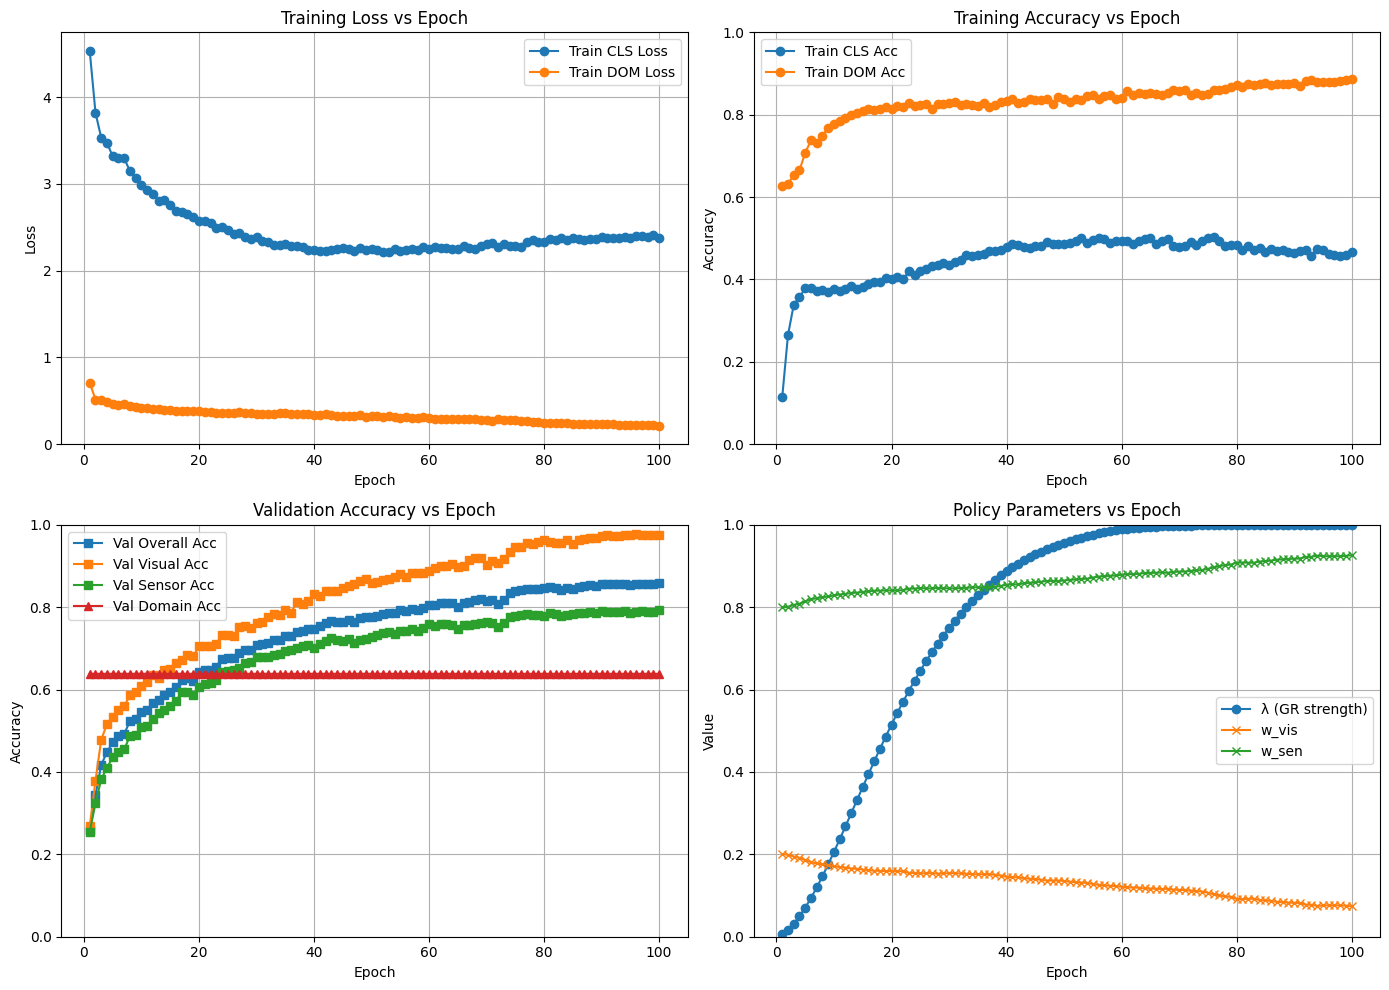

Saved plot to training_val_metrics.png


In [113]:
# Plotting: train/val metrics + policy evolution
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

def _trim(seq, n): return seq[:n]

N = len(epochs)
if N == 0:
    print("No epochs logged yet; skipping plots.")
else:
    # Training Loss
    axs[0, 0].plot(epochs, _trim(train_cls_loss, N), label='Train CLS Loss', marker='o')
    axs[0, 0].plot(epochs, _trim(train_dom_loss, N), label='Train DOM Loss', marker='o')
    axs[0, 0].set_title('Training Loss vs Epoch')
    axs[0, 0].set_xlabel('Epoch'); axs[0, 0].set_ylabel('Loss')
    axs[0, 0].legend(); axs[0, 0].grid(True)

    # Training Accuracy
    axs[0, 1].plot(epochs, _trim(train_cls_acc, N), label='Train CLS Acc', marker='o')
    axs[0, 1].plot(epochs, _trim(train_dom_acc, N), label='Train DOM Acc', marker='o')
    axs[0, 1].set_title('Training Accuracy vs Epoch')
    axs[0, 1].set_xlabel('Epoch'); axs[0, 1].set_ylabel('Accuracy')
    axs[0, 1].set_ylim(0.0, 1.0)
    axs[0, 1].legend(); axs[0, 1].grid(True)

    # Validation Accuracy
    axs[1, 0].plot(epochs, _trim(val_overall_acc, N), label='Val Overall Acc', marker='s')
    axs[1, 0].plot(epochs, _trim(val_vis_acc, N),     label='Val Visual Acc',  marker='s')
    axs[1, 0].plot(epochs, _trim(val_sen_acc, N),     label='Val Sensor Acc',  marker='s')
    vda = globals().get('val_dom_acc', [])
    if vda:
        axs[1, 0].plot(epochs, _trim(vda, N), label='Val Domain Acc', marker='^')
    axs[1, 0].set_title('Validation Accuracy vs Epoch')
    axs[1, 0].set_xlabel('Epoch'); axs[1, 0].set_ylabel('Accuracy')
    axs[1, 0].set_ylim(0.0, 1.0)
    axs[1, 0].legend(); axs[1, 0].grid(True)

    # Policy Parameters Evolution
    axs[1, 1].plot(epochs, _trim(lam_list, N),   label='λ (GR strength)', marker='o')
    axs[1, 1].plot(epochs, _trim(w_vis_list, N), label='w_vis',            marker='x')
    axs[1, 1].plot(epochs, _trim(w_sen_list, N), label='w_sen',            marker='x')
    axs[1, 1].set_title('Policy Parameters vs Epoch')
    axs[1, 1].set_xlabel('Epoch'); axs[1, 1].set_ylabel('Value')
    axs[1, 1].set_ylim(0.0, 1.0)
    axs[1, 1].legend(); axs[1, 1].grid(True)

    plt.tight_layout()
    plt.savefig('training_val_metrics.png', dpi=150)
    plt.show()
    print("Saved plot to training_val_metrics.png")


In [114]:
import cv2
import torch
import numpy as np
from torchvision import transforms
from PIL import Image
import torch.nn as nn

# Preprocess for a single RGB image
frame_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225]),
])

def preprocess_image(img_or_path) -> torch.Tensor:
    """
    Accepts a filepath, PIL.Image, numpy array (H,W,3 BGR/RGB), or CHW tensor.
    Returns a tensor of shape (1, C, H, W), normalized for an ImageNet CNN.
    """
    if isinstance(img_or_path, str):
        img = Image.open(img_or_path).convert("RGB")
    elif isinstance(img_or_path, Image.Image):
        img = img_or_path.convert("RGB")
    elif isinstance(img_or_path, np.ndarray):
        # If OpenCV BGR, convert to RGB
        if img_or_path.ndim == 3 and img_or_path.shape[2] == 3:
            # heuristic: assume BGR if coming from cv2
            img = Image.fromarray(cv2.cvtColor(img_or_path, cv2.COLOR_BGR2RGB))
        else:
            raise ValueError("NumPy image must be H×W×3.")
    elif torch.is_tensor(img_or_path):
        t = img_or_path
        if t.ndim == 3 and t.shape[0] in (1,3):  # CHW
            # assume already normalized/CHW
            return t.unsqueeze(0).float()
        else:
            raise ValueError("Tensor must be CHW with C=1 or 3.")
    else:
        raise TypeError("Unsupported image type. Use path/PIL/ndarray/tensor.")

    img_tensor = frame_transform(img)  # C,H,W
    return img_tensor.unsqueeze(0)     # 1,C,H,W

def _num_classes_for_domain(model, dom_id: int, fallback: int) -> int:
    """Infer #classes for a given domain head (multi-head), else fallback (shared head width)."""
    if getattr(model, "multi_head", False) and hasattr(model, "heads"):
        head = model.heads.get(str(int(dom_id)))
        if head is None:
            raise KeyError(f"No classification head for domain {dom_id}.")
        out_dim = None
        for m in head.modules():
            if isinstance(m, nn.Linear):
                out_dim = m.out_features
        if out_dim is None:
            raise RuntimeError(f"Could not infer out_features for domain {dom_id}.")
        return out_dim
    return int(fallback)

def predict_image_sign(
    model,
    image_input,
    device,
    label_map: dict,
    dom_id: int = 0,
    lam: float = 0.0,
    topk: int = 5,
):
    """
    Predict a sign from a single image using the model's CNN path.

    model    : SignLangDAMLModel (build_cnn=True) or compatible
    image_input : path/PIL/ndarray/tensor
    device   : 'cuda' or 'cpu'
    label_map: {class_id:int -> class_name:str} for the *visual domain* (dom_id)
    dom_id   : domain id to use for multi-head models (default 0 = visual)
    lam      : GRL strength (0 for inference)
    topk     : number of top predictions to return

    Returns:
      (top1_label:str, top1_conf:float, topk_list:[(label, conf), ...])
    """
    model.eval()

    if not hasattr(model, "cnn_feats") or model.cnn_feats is None:
        raise ValueError("Model was initialized without CNN trunk (build_cnn=False). "
                         "Provide a model with CNN enabled or pass pre-extracted features instead.")

    try:
        img_tensor = preprocess_image(image_input).to(device)  # [1,C,H,W]
        # Add time dimension T=1 for the frames path: [1,1,C,H,W]
        x_frames = img_tensor.unsqueeze(1)

        with torch.no_grad():
            if getattr(model, "multi_head", False):
                dom = torch.full((1,), int(dom_id), dtype=torch.long, device=device)
                # Try new API (lam) then fallback (lambda_)
                try:
                    cls_logits, _ = model(x_frames, lam=lam, dom=dom)
                except TypeError:
                    cls_logits, _ = model(x_frames, lambda_=lam, dom=dom)
                # Slice to valid columns for this domain head
                C_d = _num_classes_for_domain(model, dom_id, fallback=cls_logits.size(1))
                cls_logits = cls_logits[:, :C_d]
            else:
                try:
                    cls_logits, _ = model(x_frames, lam=lam)
                except TypeError:
                    cls_logits, _ = model(x_frames, lambda_=lam)

            probs = torch.softmax(cls_logits, dim=-1).squeeze(0)  # [C]
            topk = max(1, min(topk, probs.numel()))
            confs, idxs = torch.topk(probs, k=topk)

            # Map indices to names
            preds = []
            for i, c in zip(idxs.tolist(), confs.tolist()):
                preds.append((label_map.get(i, f"cls_{i}"), float(c)))

            top1_label, top1_conf = preds[0]
            return top1_label, top1_conf, preds

    except Exception as e:
        print(f"Error during image inference: {e}")
        return None, None, []


In [115]:
import torch
import torch.nn as nn
import torchvision.models as tvm

def _build_resnet18(pretrained: bool):
    """
    Handles both newer (weights=...) and older (pretrained=...) torchvision APIs.
    """
    try:
        # torchvision >= 0.13
        weights = tvm.ResNet18_Weights.DEFAULT if pretrained else None
        return tvm.resnet18(weights=weights)
    except Exception:
        # fallback for older versions
        return tvm.resnet18(pretrained=pretrained)

class VisualFeatureExtractor(nn.Module):
    """
    ResNet18 trunk → global pooled 512-D features.
    Expects BCHW input normalized to ImageNet stats.
    """
    def __init__(self, pretrained: bool = True, l2_normalize: bool = False):
        super().__init__()
        res = _build_resnet18(pretrained=pretrained)
        self.trunk = nn.Sequential(*list(res.children())[:-1])   # → [B, 512, 1, 1]
        self.out_dim = res.fc.in_features                        # 512
        self.l2_normalize = l2_normalize

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: [B, C, H, W] with C in {1,3}. If C==1, auto-repeat to 3.
        Returns: [B, 512] float tensor.
        """
        if x.ndim != 4:
            raise ValueError(f"Expected BCHW input, got shape {tuple(x.shape)}")
        if x.size(1) == 1:
            x = x.repeat(1, 3, 1, 1)
        elif x.size(1) != 3:
            raise ValueError(f"Expected C=1 or 3, got C={x.size(1)}")

        f = self.trunk(x)               # [B, 512, 1, 1]
        f = torch.flatten(f, 1)         # [B, 512]
        if self.l2_normalize:
            f = nn.functional.normalize(f, p=2, dim=1)
        return f

def build_visual_feature_extractor(
    device: torch.device,
    pretrained: bool = True,
    freeze: bool = True,
    l2_normalize: bool = False
) -> VisualFeatureExtractor:
    """
    Factory that returns an eval-mode extractor on the given device.
    If freeze=True, gradients are disabled.
    """
    m = VisualFeatureExtractor(pretrained=pretrained, l2_normalize=l2_normalize).to(device)
    m.eval()
    if freeze:
        for p in m.parameters():
            p.requires_grad = False
    return m


In [116]:
from decord import VideoReader, cpu
import numpy as np
import torch
from torchvision import transforms
from PIL import Image
import torch.nn as nn

# Fallback transform if not defined elsewhere
try:
    frame_transform
except NameError:
    frame_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406],
                             std=[0.229,0.224,0.225]),
    ])

def preprocess_video(video_path: str, num_frames: int = 16) -> torch.Tensor:
    """
    Returns a tensor shaped (1, T, C, H, W) suitable for CNN→LSTM models.
    """
    try:
        vr = VideoReader(str(video_path), ctx=cpu(0), num_threads=1)
    except Exception as e:
        print(f"Error loading video {video_path}: {e}")
        return None

    total_frames = len(vr)
    if total_frames == 0:
        print(f"No frames found in {video_path}")
        return None

    # Even sampling (duplicates are fine if total < num_frames)
    indices = np.linspace(0, total_frames - 1, num_frames, dtype=int)

    try:
        frames = vr.get_batch(indices).asnumpy()  # (T, H, W, 3), RGB uint8
    except Exception as e:
        print(f"Error getting frames from {video_path}: {e}")
        return None

    # Apply torchvision transforms per frame
    preprocessed = []
    for f in frames:
        img = Image.fromarray(f, mode='RGB')
        preprocessed.append(frame_transform(img))  # (C, H, W)

    # Stack → (T, C, H, W), then add batch → (1, T, C, H, W)
    stacked = torch.stack(preprocessed, dim=0)
    return stacked.unsqueeze(0)

def _num_classes_for_domain(model, dom_id: int, fallback: int) -> int:
    """Resolve class count for a domain head (multi-head) or use fallback."""
    if getattr(model, "multi_head", False) and hasattr(model, "heads"):
        head = model.heads.get(str(int(dom_id)))
        if head is None:
            raise KeyError(f"No classification head for domain {dom_id}.")
        out_dim = None
        for m in head.modules():
            if isinstance(m, nn.Linear):
                out_dim = m.out_features
        if out_dim is None:
            raise RuntimeError(f"Could not infer out_features for domain {dom_id}.")
        return out_dim
    return int(fallback)

def predict_video_sign(
    model,
    video_path: str,
    device,
    label_map: dict,
    num_frames: int = 16,
    dom_id: int = 0,
    lam: float = 0.0,
    topk: int = 5,
):
    """
    Predict a sign from a video using the model’s frames path.
    Returns: (top1_label:str, top1_conf:float, topk_list:[(label, conf), ...])
    """
    model.eval()

    if not hasattr(model, "cnn_feats") or model.cnn_feats is None:
        print("Model was initialized without CNN trunk (build_cnn=False).")
        return None, None, []

    try:
        vid = preprocess_video(video_path, num_frames=num_frames)
        if vid is None:
            return None, None, []
        vid = vid.to(device)  # (1, T, C, H, W)

        with torch.no_grad():
            # Multi-head needs dom ids
            if getattr(model, "multi_head", False):
                dom = torch.full((1,), int(dom_id), dtype=torch.long, device=device)
                try:
                    cls_logits, _ = model(vid, lam=lam, dom=dom)
                except TypeError:
                    cls_logits, _ = model(vid, lambda_=lam, dom=dom)
                C_d = _num_classes_for_domain(model, dom_id, fallback=cls_logits.size(1))
                cls_logits = cls_logits[:, :C_d]
            else:
                try:
                    cls_logits, _ = model(vid, lam=lam)
                except TypeError:
                    cls_logits, _ = model(vid, lambda_=lam)

            probs = torch.softmax(cls_logits, dim=-1).squeeze(0)  # [C]
            k = max(1, min(topk, probs.numel()))
            confs, idxs = torch.topk(probs, k=k)

            preds = [(label_map.get(i, f"cls_{i}"), float(c))
                     for i, c in zip(idxs.tolist(), confs.tolist())]

            top1_label, top1_conf = preds[0]
            return top1_label, top1_conf, preds

    except Exception as e:
        print(f"Error during video inference: {e}")
        return None, None, []


In [122]:
import cv2
import torch
import numpy as np
from torchvision import transforms
from PIL import Image
from IPython.display import display, Javascript

try:
    from google.colab.output import eval_js
    _IN_COLAB = True
except Exception:
    _IN_COLAB = False
from base64 import b64decode
import time

# Fallback transform if not defined earlier
try:
    frame_transform
except NameError:
    frame_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406],
                             std=[0.229,0.224,0.225]),
    ])

def preprocess_frame(frame_bgr: np.ndarray) -> torch.Tensor:
    if frame_bgr is None or frame_bgr.size == 0:
        raise ValueError("Empty frame passed to preprocess_frame.")
    img_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
    img = Image.fromarray(img_rgb)
    return frame_transform(img)  # (C, H, W)


def video_stream():
    """Start (or reuse) a webcam stream in Colab and expose robust helpers."""
    if not _IN_COLAB:
        print("Webcam streaming requires Google Colab.")
        return

    js = Javascript(r'''
      (function(){
        // Ensure a single namespace
        if (!window.__webcam) { window.__webcam = { video: null, stream: null }; }

        async function startWebcam(){
          try{
            // If already streaming, do nothing
            if (window.__webcam.stream && window.__webcam.video && window.__webcam.video.isConnected !== false) {
              return;
            }
            // Create video element
            const v = document.createElement('video');
            v.setAttribute('autoplay','');
            v.setAttribute('playsinline','');
            v.style.position='fixed';
            v.style.bottom='12px';
            v.style.right='12px';
            v.style.width='320px';
            v.style.height='240px';
            v.style.zIndex=9999;
            document.body.appendChild(v);

            // Request camera
            const stream = await navigator.mediaDevices.getUserMedia({
              video: { width: { ideal: 640 }, height: { ideal: 480 } },
              audio: false
            });

            v.srcObject = stream;
            await v.play();

            window.__webcam.video = v;
            window.__webcam.stream = stream;
            window.__webcam_started = true;
          }catch(err){
            console.error("Error accessing webcam:", err);
            alert("Webcam access failed: " + err);
          }
        }

        function captureWebcamFrame(){
          const v = window.__webcam && window.__webcam.video;
          if (!v || !v.videoWidth) return null;
          const canvas = document.createElement('canvas');
          canvas.width = v.videoWidth;
          canvas.height = v.videoHeight;
          const ctx = canvas.getContext('2d');
          ctx.drawImage(v, 0, 0, canvas.width, canvas.height);
          return canvas.toDataURL('image/jpeg', 0.85);
        }

        function stopWebcam(){
          try{
            const w = window.__webcam;
            if (w && w.stream){
              w.stream.getTracks().forEach(t => { try{ t.stop(); }catch(e){} });
              w.stream = null;
            }
            if (w && w.video){
              try { w.video.pause(); } catch(e){}
              try { w.video.srcObject = null; } catch(e){}
              if (w.video.parentNode) { w.video.parentNode.removeChild(w.video); }
              w.video = null;
            }
          }catch(e){ console.warn("stopWebcam error:", e); }
          // Extra hard-kill: stop any other video elements that still have streams
          try{
            const vids = Array.from(document.querySelectorAll('video'));
            vids.forEach(v => {
              try{
                if (v.srcObject){ v.srcObject.getTracks().forEach(t=>{ try{ t.stop(); }catch(e){} }); v.srcObject = null; }
                if (v.parentNode) v.parentNode.removeChild(v);
              }catch(e){}
            });
          }catch(e){}
          window.__webcam_started = false;
        }

        // Backwards-compat aliases
        window.startWebcam = startWebcam;
        window.captureWebcamFrame = captureWebcamFrame;
        window.stopWebcam = stopWebcam;
        window.captureFrame = captureWebcamFrame;      // legacy name
        window.stopVideoStream = stopWebcam;           // legacy name

        // Auto-start
        startWebcam();
      })();
    ''')
    display(js)

def wait_for_webcam_ready(max_wait_sec: float = 12.0) -> bool:
    if not _IN_COLAB:
        return False
    t0 = time.time()
    while time.time() - t0 < max_wait_sec:
        try:
            data = eval_js('typeof captureWebcamFrame==="function" ? captureWebcamFrame() : (typeof captureFrame==="function" ? captureFrame() : null)')
        except Exception:
            data = None
        if data:
            return True
        time.sleep(0.25)
    return False

def _grab_colab_frame() -> np.ndarray | None:
    if not _IN_COLAB:
        return None
    try:
        data = eval_js('typeof captureWebcamFrame==="function" ? captureWebcamFrame() : (typeof captureFrame==="function" ? captureFrame() : null)')
    except Exception:
        data = None
    if not data:
        return None
    try:
        binary = b64decode(data.split(',')[1])
        np_img = np.frombuffer(binary, dtype=np.uint8)
        return cv2.imdecode(np_img, cv2.IMREAD_COLOR)  # BGR
    except Exception:
        return None

def stop_webcam():
    """Robustly stop the webcam and remove the DOM element (with a hard-kill fallback)."""
    if not _IN_COLAB:
        return
    # Try the JS function directly via eval_js (synchronously)
    try:
        eval_js('(function(){ if (typeof stopWebcam==="function") { stopWebcam(); return "ok"; } if (typeof stopVideoStream==="function") { stopVideoStream(); return "legacy"; } return "no-fn"; })()')
    except Exception:
        pass
    # Fire a last-resort cleanup on the front-end too (covers cases where eval_js context changed)
    display(Javascript(r'''
      (function(){
        try { if (typeof stopWebcam === 'function') stopWebcam(); } catch(e){}
        try {
          const vids = Array.from(document.querySelectorAll('video'));
          vids.forEach(v => {
            try{
              if (v.srcObject){ v.srcObject.getTracks().forEach(t=>{ try{ t.stop(); }catch(e){} }); v.srcObject = null; }
              if (v.parentNode) v.parentNode.removeChild(v);
            }catch(e){}
          });
        } catch(e){}
        if (window.__webcam){ window.__webcam.stream = null; window.__webcam.video = null; }
        window.__webcam_started = false;
      })();
    '''))


In [123]:
import torch
import numpy as np
import pandas as pd
from typing import Optional, Tuple, Dict

# --------------------------- Preprocess (numpy → tensor) ---------------------------

def preprocess_sensor_data(
    sensor_data: np.ndarray,
    seq_len: int = 100,
    normalize: bool = True
) -> torch.Tensor:
    """
    Preprocess raw sensor data (numpy array of shape [T_raw, C]).
    Returns a FloatTensor of shape [1, seq_len, C].
    - Evenly samples or zero-pads to seq_len
    - Optional per-channel z-score (numerically stable)
    """
    if sensor_data is None or not isinstance(sensor_data, np.ndarray):
        raise ValueError("sensor_data must be a NumPy array.")
    if sensor_data.ndim != 2:
        raise ValueError(f"sensor_data must be 2D [T, C], got shape {sensor_data.shape}.")

    T_raw, C = sensor_data.shape

    if T_raw >= seq_len:
        idx = np.linspace(0, T_raw - 1, seq_len, dtype=int)
        data_seq = sensor_data[idx]
    else:
        pad = np.zeros((seq_len - T_raw, C), dtype=sensor_data.dtype)
        data_seq = np.vstack([sensor_data, pad])

    if normalize:
        mu = data_seq.mean(axis=0, keepdims=True)
        sd = data_seq.std(axis=0, keepdims=True)
        data_seq = (data_seq - mu) / (sd + 1e-8)

    return torch.as_tensor(data_seq, dtype=torch.float32).unsqueeze(0)  # [1, T, C]


# --------------------------- CSV loader (+ preprocessing) --------------------------

def load_and_preprocess_sensor_file(
    filepath: str,
    seq_len: int = 100,
    normalize: bool = True,
    drop_cols: Tuple[str, ...] = ("timestamp", "user_id")
) -> Optional[torch.Tensor]:
    """
    Loads a CSV and returns preprocessed tensor [1, seq_len, C].
    - Silently ignores missing drop_cols.
    - Coerces non-numeric columns to numeric (errors→NaN) and fills NaNs with 0.
    """
    try:
        df = pd.read_csv(filepath)

        # Drop known non-sensor columns if present
        to_drop = [c for c in drop_cols if c in df.columns]
        if to_drop:
            df = df.drop(columns=to_drop)

        # Keep only numeric; coerce non-numeric to NaN then fill 0
        for c in df.columns:
            if not pd.api.types.is_numeric_dtype(df[c]):
                df[c] = pd.to_numeric(df[c], errors="coerce")
        df = df.fillna(0.0)

        if df.shape[1] == 0:
            raise ValueError("No numeric sensor columns found after cleaning.")

        sensor_data = df.to_numpy(dtype=np.float32)  # [T_raw, C]
        return preprocess_sensor_data(sensor_data, seq_len=seq_len, normalize=normalize)
    except Exception as e:
        print(f"Error loading or preprocessing sensor file '{filepath}': {e}")
        return None


# --------------------------- Feature extraction (Masked GRU) -----------------------

def predict_sensor_sign(
    model,  # MaskedSensorFeatureGRU (feature extractor)
    sensor_data_input: torch.Tensor,
    device
) -> Optional[torch.Tensor]:
    """
    Backwards-compatible shim that returns features only.
    Expects input shape [1, T, C]. Returns features [1, 512] (or model.hidden_dim).
    """
    try:
        model.eval()
        x = sensor_data_input.to(device)
        with torch.no_grad():
            feats, _, _ = model(x)          # [1, D]
        return feats
    except Exception as e:
        print(f"Error during sensor inference: {e}")
        return None


def get_sensor_features(
    raw_sensor_filepath: str,
    sensor_feature_extractor_model,  # MaskedSensorFeatureGRU
    device,
    seq_len: int = 100,
    normalize: bool = True
) -> Optional[torch.Tensor]:
    """
    Loads CSV → preprocess → extract features with MaskedSensorFeatureGRU.
    Returns [1, D] tensor or None on failure.
    """
    try:
        x = load_and_preprocess_sensor_file(raw_sensor_filepath, seq_len, normalize)
        if x is None:
            return None
        sensor_feature_extractor_model.eval()
        x = x.to(device)
        with torch.no_grad():
            feats, _, _ = sensor_feature_extractor_model(x)  # [1, D]
        return feats
    except Exception as e:
        print(f"Error during sensor feature extraction: {e}")
        return None


# --------------------------- classify via DAML model ---------------------

def _slice_logits_for_domain(model, dom_id: int, cls_logits: torch.Tensor) -> torch.Tensor:
    """For multi-head models, slice logits to the correct width for dom_id."""
    import torch.nn as nn
    if getattr(model, "multi_head", False) and hasattr(model, "heads"):
        key = str(int(dom_id))
        if key not in model.heads:
            raise KeyError(f"No classification head for domain {dom_id}.")
        head = model.heads[key]
        # infer the head’s output width
        out_dim = None
        for m in head.modules():
            if isinstance(m, nn.Linear):
                out_dim = m.out_features
        if out_dim is None:
            raise RuntimeError(f"Could not infer out_features for domain {dom_id}.")
        return cls_logits[:, :out_dim]
    return cls_logits


def classify_sensor_features_with_daml(
    daml_model,             # SignLangDAMLModel (multi-head or single-head)
    feats_1xD: torch.Tensor,  # [1, D] features from MaskedSensorFeatureGRU
    device,
    label_map: Dict[int, str],
    dom_id: int = 1,        # sensor domain id (0 is visual by convention)
    lam: float = 0.0,
    topk: int = 5
):
    """
    Runs classification on pre-extracted features through the DAML model.
    Returns (top1_label, top1_conf, topk_list) or (None, None, []) on failure.
    """
    try:
        daml_model.eval()
        x = feats_1xD.to(device)  # [1, D]
        with torch.no_grad():
            if getattr(daml_model, "multi_head", False):
                dom = torch.tensor([dom_id], dtype=torch.long, device=device)
                try:
                    cls_logits, _ = daml_model(x, lam=lam, dom=dom)
                except TypeError:
                    cls_logits, _ = daml_model(x, lambda_=lam, dom=dom)
                cls_logits = _slice_logits_for_domain(daml_model, dom_id, cls_logits)
            else:
                try:
                    cls_logits, _ = daml_model(x, lam=lam)
                except TypeError:
                    cls_logits, _ = daml_model(x, lambda_=lam)

            probs = torch.softmax(cls_logits, dim=-1).squeeze(0)
            k = max(1, min(topk, probs.numel()))
            confs, idxs = torch.topk(probs, k=k)
            preds = [(label_map.get(i, f"cls_{i}"), float(c))
                     for i, c in zip(idxs.tolist(), confs.tolist())]
            top1_label, top1_conf = preds[0]
            return top1_label, top1_conf, preds
    except Exception as e:
        print(f"Error during DAML sensor classification: {e}")
    return None, None, []


# --------------------------- Unified label space (100 classes) ---------------------

def unified_label_map() -> Tuple[Dict[str, int], Dict[int, str]]:
    """
    Returns:
      - label_to_index: str → int
      - index_to_label: int → str
    for a unified 100-class space (digits, letters, selected glosses/words/handshapes).
    """
    total_unique_labels = [
        # 10 digits
        '0','1','2','3','4','5','6','7','8','9',
        # 26 letters
        'a','b','c','d','e','f','g','h','i','j',
        'k','l','m','n','o','p','q','r','s','t',
        'u','v','w','x','y','z',
        # 16 video glosses
        'thousand','off','character','shoes','earn','fault',
        'neutral','swallow','cigarette','past','who','blame',
        'warn','mexico','company','wife',
        # 14 sensor words
        'bad','deaf','fine','good','goodbye','hello',
        'hungry','me','no','please','sorry','thankyou',
        'yes','you',
        # 34 handshape composites
        'baby_o','bent_1','bent_l','bent_v','closed_b','closed_e',
        'curved_1','curved_4','curved_5','curved_h','curved_l',
        'curved_v','flat_1','flat_4','flat_b','flat_h','flat_horns',
        'flat_ily','flat_m','flat_n','flat_o','flat_v','flatspread_5',
        'goody_goody','horns','ily','open_8','open_b','open_e',
        'open_f','open_h','spread_e','spread_open_e','stacked_5'
    ]
    assert len(total_unique_labels) == 100, f"Expected 100 labels, got {len(total_unique_labels)}"
    label_to_index = {lbl: i for i, lbl in enumerate(total_unique_labels)}
    index_to_label = {i: lbl for lbl, i in label_to_index.items()}
    return label_to_index, index_to_label


In [124]:
# Build our unified label maps (assumes unified_label_map() is already defined)
label_to_idx, idx_to_label = unified_label_map()

import os, time
import torch
import torch.nn as nn

# Small helper just for display
def _print_topk(preds):
    if not preds:
        return
    try:
        print("Top-k:")
        for i, (lbl, p) in enumerate(preds, 1):
            print(f"  {i:>2d}. {lbl:<20s}  {p:.4f}")
    except Exception:
        pass

def run_validation(
    model,
    sensor_feature_extractor_model,
    device,
    idx_to_label: dict,
    sensor_label_map: dict | None = None,
    visual_dom_id: int = 0,
    sensor_dom_id: int = 1,
    topk: int = 5,
    webcam_clip: bool = False,
    webcam_T: int = 16,
    webcam_interval: float = 0.08,
    vis_extractor: nn.Module | None = None,
):
    """
    Interactive validator for:
      1) Image
      2) Video
      3) Webcam (single frame or short clip)
      4) Sensor CSV
    Notes:
      - If the DAML model has no CNN trunk (build_cnn=False), pass `vis_extractor`
        so images/videos/webcam can still be classified via the feature path.
    """
    if sensor_label_map is None:
        sensor_label_map = idx_to_label

    # quick capabilities check
    has_cnn = hasattr(model, "cnn_feats") and (model.cnn_feats is not None)
    if not has_cnn and vis_extractor is None:
        print("Model has no CNN trunk and no external visual extractor was provided.")
        print("→ Visual inference (image/video/webcam) will be unavailable.")
    elif not has_cnn and vis_extractor is not None:
        print("Model has no CNN trunk; using external visual feature extractor for visual inference.")

    menu = """
Sign Language Detection Validation
1. Upload Image
2. Upload Video
3. Use Webcam
4. Use Sensor CSV
5. Exit
"""
    print(menu)

    while True:
        choice = input("Enter your choice (1-5): ").strip()

        # ────────────────────────── 1) IMAGE ──────────────────────────
        if choice == '1':
            path = input("Path to image file: ").strip()
            if not os.path.exists(path):
                print("File not found.")
            else:
                try:
                    top1, conf, preds = predict_image_sign(
                        model=model,
                        image_input=path,
                        device=device,
                        label_map=idx_to_label,
                        dom_id=visual_dom_id,
                        lam=0.0,
                        topk=topk,
                        vis_extractor=vis_extractor
                    )
                except TypeError:
                    # fall back to a manual path using the extractor + DAML.
                    if has_cnn:
                        top1, conf, preds = predict_image_sign(
                            model=model, image_input=path, device=device,
                            label_map=idx_to_label, dom_id=visual_dom_id,
                            lam=0.0, topk=topk
                        )
                    else:
                        # Manual fallback: extract features → classify through DAML
                        from PIL import Image
                        from torchvision import transforms
                        img = Image.open(path).convert("RGB")
                        x = frame_transform(img).unsqueeze(0).to(device)   # [1,3,224,224]
                        with torch.no_grad():
                            f = vis_extractor(x)                            # [1,512]
                            dom = torch.tensor([visual_dom_id], dtype=torch.long, device=device)
                            try:
                                logits, _ = model(f, lam=0.0, dom=dom)
                            except TypeError:
                                logits, _ = model(f, lambda_=0.0, dom=dom)
                            C = logits.size(1)
                            if getattr(model, "multi_head", False) and hasattr(model, "heads"):
                                head = model.heads[str(int(visual_dom_id))]
                                out_dim = None
                                for m in head.modules():
                                    if isinstance(m, nn.Linear):
                                        out_dim = m.out_features
                                if out_dim is not None and out_dim < C:
                                    logits = logits[:, :out_dim]
                            probs = torch.softmax(logits, dim=-1).squeeze(0)
                            k = min(topk, probs.numel())
                            confs, idxs = torch.topk(probs, k=k)
                            preds = [(idx_to_label.get(i, f"cls_{i}"), float(c))
                                     for i, c in zip(idxs.tolist(), confs.tolist())]
                            top1, conf = preds[0]

                if top1 is not None:
                    print(f"Prediction: {top1}  Confidence: {conf:.4f}")
                    _print_topk(preds)
                else:
                    print("Could not process image.")

        # ────────────────────────── 2) VIDEO ──────────────────────────
        elif choice == '2':
            path = input("Path to video file: ").strip()
            if not os.path.exists(path):
                print("File not found.")
            else:
                try:
                    top1, conf, preds = predict_video_sign(
                        model=model,
                        video_path=path,
                        device=device,
                        label_map=idx_to_label,
                        num_frames=100,
                        dom_id=visual_dom_id,
                        lam=0.0,
                        topk=topk,
                        vis_extractor=vis_extractor  # <─ NEW
                    )
                except TypeError:
                    # Fallback: if predict_video_sign hasn't been updated to accept vis_extractor
                    # and model lacks a CNN, we can't run from path here. Suggest extracting frames
                    # first or update predict_video_sign.
                    if not has_cnn:
                        print("Your predict_video_sign() doesn't accept vis_extractor yet. "
                              "Please update it to support external extractor fallback.")
                        top1, conf, preds = None, None, []
                    else:
                        top1, conf, preds = predict_video_sign(
                            model=model, video_path=path, device=device,
                            label_map=idx_to_label, num_frames=100,
                            dom_id=visual_dom_id, lam=0.0, topk=topk
                        )

                if top1 is not None:
                    print(f"Prediction: {top1}  Confidence: {conf:.4f}")
                    _print_topk(preds)
                else:
                    print("Could not process video.")

        # ──────────────────────── 3) WEBCAM ──────────────────────────
        elif choice == '3':
            print("Starting webcam. Ctrl+C to stop.")
            try:
                try:
                    video_stream()
                except NameError:
                    print("video_stream() not found. Define webcam helpers or run in Colab.")
                    raise KeyboardInterrupt

                time.sleep(2.0)

                if webcam_clip:
                    while True:
                        clip = capture_clip_and_process(num_frames=webcam_T, interval_sec=webcam_interval).to(device)

                        with torch.no_grad():
                            if has_cnn:
                                dom = torch.tensor([visual_dom_id], dtype=torch.long, device=device)
                                try:
                                    logits, _ = model(clip, lam=0.0, dom=dom)
                                except TypeError:
                                    logits, _ = model(clip, lambda_=0.0, dom=dom)
                                if getattr(model, "multi_head", False) and hasattr(model, "heads"):
                                    head = model.heads[str(int(visual_dom_id))]
                                    out_dim = None
                                    for m in head.modules():
                                        if isinstance(m, nn.Linear):
                                            out_dim = m.out_features
                                    if out_dim is not None and out_dim < logits.size(1):
                                        logits = logits[:, :out_dim]
                                probs = torch.softmax(logits, dim=-1).squeeze(0)
                            else:
                                # External extractor fallback: per-frame features → mean-pool → DAML
                                frames = clip.squeeze(0)              # [T,C,H,W]
                                feats  = vis_extractor(frames)        # [T,512]
                                feat   = feats.mean(dim=0, keepdim=True)  # [1,512]
                                dom    = torch.tensor([visual_dom_id], dtype=torch.long, device=device)
                                try:
                                    logits, _ = model(feat, lam=0.0, dom=dom)
                                except TypeError:
                                    logits, _ = model(feat, lambda_=0.0, dom=dom)
                                # slice to head width if multi-head
                                if getattr(model, "multi_head", False) and hasattr(model, "heads"):
                                    head = model.heads[str(int(visual_dom_id))]
                                    out_dim = None
                                    for m in head.modules():
                                        if isinstance(m, nn.Linear):
                                            out_dim = m.out_features
                                    if out_dim is not None and out_dim < logits.size(1):
                                        logits = logits[:, :out_dim]
                                probs = torch.softmax(logits, dim=-1).squeeze(0)

                            idx  = int(torch.argmax(probs).item())
                            conf = float(torch.max(probs).item())
                            lbl  = idx_to_label.get(idx, "Unknown")

                        print(f"\r{lbl}  {conf:.4f}", end='')
                        time.sleep(0.05)

                else:
                    # Single-frame mode
                    while True:
                        frame_chw = capture_frame_and_process().to(device)  # [C,H,W]
                        with torch.no_grad():
                            if has_cnn:
                                try:
                                    top1, conf, _ = predict_image_sign(
                                        model=model, image_input=frame_chw,
                                        device=device, label_map=idx_to_label,
                                        dom_id=visual_dom_id, lam=0.0, topk=1
                                    )
                                except TypeError:
                                    top1, conf, _ = predict_image_sign(
                                        model=model, image_input=frame_chw,
                                        device=device, label_map=idx_to_label,
                                        dom_id=visual_dom_id, lam=0.0, topk=1
                                    )
                            else:
                                # External extractor fallback
                                x  = frame_chw.unsqueeze(0)          # [1,C,H,W]
                                f  = vis_extractor(x)                 # [1,512]
                                dom = torch.tensor([visual_dom_id], dtype=torch.long, device=device)
                                try:
                                    logits, _ = model(f, lam=0.0, dom=dom)
                                except TypeError:
                                    logits, _ = model(f, lambda_=0.0, dom=dom)
                                # slice to head width if multi-head
                                if getattr(model, "multi_head", False) and hasattr(model, "heads"):
                                    head = model.heads[str(int(visual_dom_id))]
                                    out_dim = None
                                    for m in head.modules():
                                        if isinstance(m, nn.Linear):
                                            out_dim = m.out_features
                                    if out_dim is not None and out_dim < logits.size(1):
                                        logits = logits[:, :out_dim]
                                probs = torch.softmax(logits, dim=-1).squeeze(0)
                                idx   = int(torch.argmax(probs).item())
                                conf  = float(torch.max(probs).item())
                                top1  = idx_to_label.get(idx, "Unknown")

                        if top1 is None:
                            print("\r<capture error>", end='')
                        else:
                            print(f"\r{top1}  {conf:.4f}", end='')
                        time.sleep(0.1)

            except KeyboardInterrupt:
                print("\nWebcam stopped.")
            finally:
                try:
                    stop_webcam()
                except NameError:
                    pass

        # ──────────────────────── 4) SENSOR CSV ──────────────────────
        elif choice == '4':
            path = input("Path to sensor CSV: ").strip()
            if not os.path.exists(path):
                print("File not found.")
            else:
                feats = get_sensor_features(
                    raw_sensor_filepath=path,
                    sensor_feature_extractor_model=sensor_feature_extractor_model,
                    device=device,
                    seq_len=100,
                    normalize=True
                )
                if feats is None:
                    print("Could not process sensor data.")
                else:
                    top1, conf, preds = classify_sensor_features_with_daml(
                        daml_model=model,
                        feats_1xD=feats,
                        device=device,
                        label_map=sensor_label_map,
                        dom_id=sensor_dom_id,
                        lam=0.0,
                        topk=topk
                    )
                    if top1 is None:
                        print("Sensor classification failed.")
                    else:
                        print(f"Prediction (Sensor): {top1}  Confidence: {conf:.4f}")
                        _print_topk(preds)

        # ────────────────────────── 5) EXIT ──────────────────────────
        elif choice == '5':
            print("Exiting validation.")
            break

        else:
            print("Invalid choice. Please enter a number between 1 and 5.")

        # repeat/quit prompt
        print("\nRetest or Exit?")
        cmd = input("Enter 'retest' to try again or 'exit' to quit: ").strip().lower()
        if cmd == 'exit':
            print("Exiting validation.")
            break
        print("-" * 40)


In [125]:
# ===== Validation entrypoint =====
import torch
from typing import Optional

try:
    label_to_idx, idx_to_label
except NameError:
    label_to_idx, idx_to_label = unified_label_map()

def start_validation(
    model: torch.nn.Module,
    sensor_feature_extractor_model: Optional[torch.nn.Module] = None,
    device: Optional[torch.device] = None,
    topk: int = 5,
    webcam_clip: bool = False,
    webcam_T: int = 16,
    webcam_interval: float = 0.08,
    visual_dom_id: int = 0,
    sensor_dom_id: int = 1,
):
    """
    Launch the interactive validator (image/video/webcam/sensor CSV).

    - If the DAML model was built WITHOUT a CNN trunk (build_cnn=False),
      we automatically build a frozen ResNet18 visual feature extractor
      and route visual inputs through the feature path.

    - If `sensor_feature_extractor_model` is None, the Sensor CSV menu item
      will be shown but will print a friendly message if selected.
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Move models to device (guard sensor model being None)
    model.to(device)
    if sensor_feature_extractor_model is not None:
        sensor_feature_extractor_model.to(device)

    # Info
    print(f"Device: {device}")
    if getattr(model, "multi_head", False) and hasattr(model, "heads"):
        print(f"Multi-head model detected. Heads: {list(model.heads.keys())}")
    else:
        print("Single-head model detected.")

    # Decide visual path: CNN trunk vs external extractor
    has_cnn = hasattr(model, "cnn_feats") and (model.cnn_feats is not None)
    vis_extractor = None
    if not has_cnn:
        print("Model has no CNN trunk; using external ResNet18 feature extractor for visual inference.")
        try:
            vis_extractor = build_visual_feature_extractor(device, pretrained=True, freeze=True)
        except NameError:
            import torch.nn as nn
            import torchvision.models as tvm

            class _InlineRes18(nn.Module):
                def __init__(self):
                    super().__init__()
                    res = tvm.resnet18(weights=tvm.ResNet18_Weights.DEFAULT)
                    self.trunk = nn.Sequential(*list(res.children())[:-1])  # [B,512,1,1]
                def forward(self, x):
                    if x.size(1) == 1:
                        x = x.repeat(1, 3, 1, 1)
                    f = self.trunk(x)
                    return f.view(f.size(0), -1)

            vis_extractor = _InlineRes18().to(device).eval()
            for p in vis_extractor.parameters():
                p.requires_grad = False

    sensor_label_map = idx_to_label

    if sensor_feature_extractor_model is None:
        print("Note: No sensor feature extractor provided — Sensor CSV option will be disabled.")

    # Hand off to the interactive validator
    run_validation(
        model=model,
        sensor_feature_extractor_model=sensor_feature_extractor_model if sensor_feature_extractor_model is not None else model,
        device=device,
        idx_to_label=idx_to_label,
        sensor_label_map=sensor_label_map,
        visual_dom_id=visual_dom_id,
        sensor_dom_id=sensor_dom_id,
        topk=topk,
        webcam_clip=webcam_clip,
        webcam_T=webcam_T,
        webcam_interval=webcam_interval,
        vis_extractor=vis_extractor,
    )

# ---- Kick it off ----
start_validation(
    model=model,
    sensor_feature_extractor_model=None,
    topk=5,
    webcam_clip=False
)


Device: cpu
Multi-head model detected. Heads: ['0', '1', '2', '3', '4']
Model has no CNN trunk; using external ResNet18 feature extractor for visual inference.
Note: No sensor feature extractor provided — Sensor CSV option will be disabled.
Model has no CNN trunk; using external visual feature extractor for visual inference.

Sign Language Detection Validation
1. Upload Image
2. Upload Video
3. Use Webcam
4. Use Sensor CSV
5. Exit

Enter your choice (1-5): 3
Starting webcam. Ctrl+C to stop.


<IPython.core.display.Javascript object>

j  0.9998
Webcam stopped.


<IPython.core.display.Javascript object>


Retest or Exit?
Enter 'retest' to try again or 'exit' to quit: exit
Exiting validation.
